# Desenvolvimento de modelos preditivos de volumes pulmonares estáticos com base em parâmetros espirométricos

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
# Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

%matplotlib inline

In [2]:
# Carregar datasets
PFT = pd.read_excel (r'C:\Users\marco\OneDrive\Documentos\Trabalhos HLUZ\PFT AI_raw.xlsx')

## Exploratory Data Anaysis

In [3]:
PFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14646 entries, 0 to 14645
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 14646 non-null  int64  
 1   sex                 14646 non-null  object 
 2   date                14646 non-null  object 
 3   height              14646 non-null  float64
 4   tlc                 8979 non-null   float64
 5   tlco                9544 non-null   float64
 6   fev1_pos            6105 non-null   float64
 7   fev1_pre            14646 non-null  float64
 8   fev1_fvc_pos        6104 non-null   float64
 9   fev1/fvc_pre        14646 non-null  float64
 10  fvc_pos             6105 non-null   float64
 11  fvc_pre             14646 non-null  float64
 12  weight              14610 non-null  float64
 13  vc                  14646 non-null  float64
 14  Bronchodilator      6121 non-null   object 
 15  rv                  8973 non-null   float64
 16  Ep  

In [4]:
#fev1_pos e fvc_pos deciam ter o mesmo nr de nan
#if fvc_pos = np.nan then pd.replace fev1_pos = np.nan

In [5]:
pd.options.display.max_columns = 65 #mostrar todas as colunas

In [6]:
PFT['rv_tlc']=PFT['rv']/PFT['tlc'] 

#### Espirometrias basais: 14 624
#### Espirometrias com volumes pulmonares estáticos: 8 973
#### Difusões: 9 544 
#### Provas de broncodilatação: 6 105 

In [7]:
print(PFT['NHC'].nunique())

12230


NHC é o número identificativo do doente
#### Logo existem 12 230 doentes, alguns repetiram o exame (em ~ 3anos)

In [8]:
PFT.describe()

age        height          tlc         tlco     fev1_pos  \
count  14646.000000  14646.000000  8979.000000  9544.000000  6105.000000   
mean      51.644954    163.908568     6.114739     6.439363     2.640671   
std       20.029704     14.746259     7.593137     2.205628     1.022524   
min        4.000000      0.000000     0.560000     0.430000     0.139606   
25%       39.000000    157.000000     4.870000     4.910000     1.872250   
50%       54.000000    165.000000     5.690000     6.250000     2.550744   
75%       68.000000    173.000000     6.750000     7.840000     3.280870   
max      100.000000    769.000000   558.000000    15.000000     6.503296   

           fev1_pre  fev1_fvc_pos  fev1/fvc_pre      fvc_pos       fvc_pre  \
count  14646.000000   6104.000000  14646.000000  6105.000000  14646.000000   
mean       2.732118     73.833732     76.697009     3.556483      3.552356   
std        0.990171     12.710514     10.488957     1.174051      1.180191   
min        0.350000      8.410000      1.850000     0.610000      0.390000   
25%        2.000000     66.690000     71.972500     2.710000      2.710000   
50%        2.680000     74.860000     78.350000     3.480000      3.480000   
75%        3.380000     83.222500     83.320000     4.300000      4.320000   
max        6.680000     99.910000    100.000000     8.500000     11.680000   

             weight            vc           rv  fev1_pre_predicted  \
count  14610.000000  14646.000000  8973.000000        14559.000000   
mean      73.019446      2.038831     2.790986            2.932785   
std       20.435381      7.410023     8.218043            0.850033   
min        1.000000   -282.500000     0.340000            0.208000   
25%       60.000000      0.000000     1.670000            2.298000   
50%       72.000000      2.560000     2.100000            2.883000   
75%       84.000000      3.820000     2.560000            3.479000   
max      589.000000    555.900000   287.000000            6.744000   

       fev1_pre_lln  fev1_pre_uln    fev1_pre_z   fev1_pre_pp  fvc_predicted  \
count  14559.000000  14559.000000  14559.000000  14559.000000   14559.000000   
mean       2.253204      3.582989     -0.360836     93.736533       3.664646   
std        0.714659      0.987170      2.936245     33.662449       1.040188   
min        0.141000      0.273000     -6.302000     16.189000       0.242000   
25%        1.702000      2.849000     -1.236000     82.133500       2.908000   
50%        2.211000      3.533000     -0.429000     94.027000       3.601000   
75%        2.722000      4.220000      0.398500    105.325500       4.355000   
max        5.392000      8.050000    120.141000   1248.847000       8.456000   

        fvc_pre_lln   fvc_pre_uln     fvc_pre_z    fvc_pre_pp  \
count  14559.000000  14559.000000  14559.000000  14559.000000   
mean       2.829563      4.522229     -0.144804     98.010173   
std        0.868005      1.214968      2.432938     37.169315   
min        0.163000      0.299000     -7.576000     15.012000   
25%        2.190000      3.660000     -0.929000     86.817500   
50%        2.791000      4.427000     -0.194000     97.242000   
75%        3.370500      5.369000      0.515000    107.159500   
max        6.817000     10.112000    114.082000   1549.837000   

       fev1fvc_pre_dicted  fev1fvc_pre_lln  fev1fvc_pre_uln  fev1fvc_pre_z  \
count        14559.000000     14559.000000     14559.000000   14559.000000   
mean             0.804904         0.683646         0.907411      -0.429903   
std              0.036577         0.045826         0.026904       1.281616   
min              0.735000         0.572000         0.863000      -5.249000   
25%              0.780000         0.650000         0.890000      -1.102000   
50%              0.796000         0.682000         0.900000      -0.313000   
75%              0.821000         0.712000         0.912000       0.359000   
max              1.003000         0.878000         1.103000      4

In [9]:
PFT.rename(columns = {'fev1/fvc_pre':'fev1_fvc_pre'}, inplace=True)

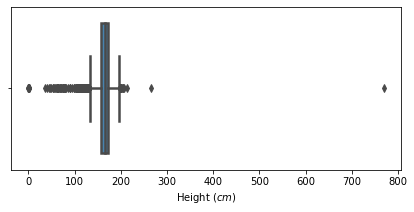

In [10]:
plt.figure(figsize=(7,3))
sns.boxplot(x="height", data=PFT, linewidth=2.5, palette="Blues_d")
plt.xlabel('Height ($cm$)')
plt.show()

#### Existem alguns dados que são erros (i.e. height = 769 cm), pelo que serão removidos

#### Base de dados só com adultos

In [11]:
PFT=PFT.loc[PFT.height<200]
PFT=PFT.loc[PFT.height>130]
PFT=PFT.loc[PFT.weight<200]
PFT=PFT.loc[PFT.tlc<15]
PFT=PFT.loc[PFT.rv<10]
PFT=PFT.loc[PFT.rv_tlc<0.9]
PFT=PFT.loc[PFT.rv_tlc<0.9]
PFT=PFT.loc[PFT.age>17]
PFT=PFT.loc[PFT.age<=80] #zscores de volumes
PFT=PFT.loc[PFT.fev1fvc_pre_z<7] #outlier detectado no scatter plot
PFT=PFT.loc[PFT.weight>25] #outlier detectado no boxplot
PFT.describe()

age       height          tlc         tlco     fev1_pos  \
count  8146.000000  8146.000000  8146.000000  6434.000000  3510.000000   
mean     53.028971   166.273324     5.931113     6.597575     2.794079   
std      16.044219     9.840912     1.295070     2.138877     1.000723   
min      18.000000   136.000000     1.540000     0.800000     0.471408   
25%      42.000000   159.000000     4.990000     5.100000     2.043467   
50%      54.000000   166.000000     5.780000     6.390000     2.739117   
75%      67.000000   174.000000     6.810000     7.927500     3.398745   
max      80.000000   198.000000    11.390000    15.000000     6.471840   

          fev1_pre  fev1_fvc_pos  fev1_fvc_pre      fvc_pos      fvc_pre  \
count  8146.000000   3509.000000   8146.000000  3510.000000  8146.000000   
mean      2.852379     73.955329     76.412521     3.748168     3.714811   
std       0.947762     12.191561     10.081662     1.121018     1.107302   
min       0.370000     10.060000      1.950000     0.930000     0.650000   
25%       2.170000     67.340000     71.962500     2.920000     2.920000   
50%       2.790000     75.000000     78.100000     3.630000     3.610000   
75%       3.460000     82.760000     82.780000     4.457500     4.420000   
max       6.160000     99.750000     99.960000     8.340000     8.210000   

            weight           vc           rv  fev1_pre_predicted  \
count  8146.000000  8146.000000  8146.000000         8146.000000   
mean     75.442200     3.755809     2.175304            3.048901   
std      17.305417     1.107698     0.706933            0.786687   
min      33.000000     0.650000     0.340000            1.345000   
25%      63.000000     2.950000     1.700000            2.458000   
50%      74.000000     3.640000     2.100000            2.988000   
75%      85.000000     4.460000     2.530000            3.547000   
max     171.000000     9.080000     6.910000            5.770000   

       fev1_pre_lln  fev1_pre_uln   fev1_pre_z  fev1_pre_pp  fvc_predicted  \
count   8146.000000   8146.000000  8146.000000  8146.000000    8146.000000   
mean       2.345578      3.721787    -0.439391    93.205793       3.819562   
std        0.669182      0.905908     1.250935    18.404770       0.949308   
min        0.941000      1.730000    -6.302000    19.213000       1.727000   
25%        1.830000      3.044000    -1.184750    83.001500       3.118000   
50%        2.293000      3.647000    -0.393000    94.677500       3.721000   
75%        2.767000      4.305000     0.413000   105.577250       4.457000   
max        4.621000      6.881000     4.851000   165.238000       7.114000   

       fvc_pre_lln  fvc_pre_uln    fvc_pre_z   fvc_pre_pp  fev1fvc_pre_dicted  \
count  8146.000000  8146.000000  8146.000000  8146.000000         8146.000000   
mean      2.952799     4.709596    -0.204513    97.170493            0.800782   
std       0.802430     1.095272     1.104896    15.793675            0.028800   
min       1.210000     2.273000    -7.098000    19.807000            0.742000   
25%       2.360000     3.885000    -0.894000    87.402000            0.781000   
50%       2.893000     4.575000    -0.163000    97.757500            0.796000   
75%       3.455000     5.494000     0.529750   107.424250            0.815000   
max       5.740000     8.502000     4.634000   165.516000            0.900000   

       fev1fvc_pre_lln  fev1fvc_pre_uln  fev1fvc_pre_z  fev1fvc_pre_pp  \
count      8146.000000      8146.000000    8146.000000     8146.000000   
mean          0.680595         0.902802      -0.426615       95.435355   
std           0.036927         0.021099       1.175759       11.525235   
min           0.595000         0.867000      -5.249000       30.337000   
25%           0.652000         0.889000      -1.070750       90.562000   
50%           0.680000         0.898000      -0.298000       97.545000   
75%           0.706000         0.906000       0.357000      102.868000   
max           0.785000   

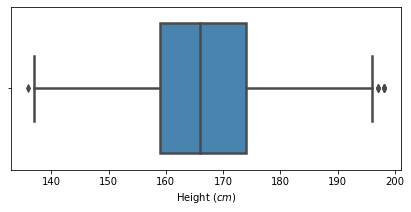

In [12]:
plt.figure(figsize=(7,3))
sns.boxplot(x="height", data=PFT, linewidth=2.5, palette="Blues_d")
plt.xlabel('Height ($cm$)')
plt.show()

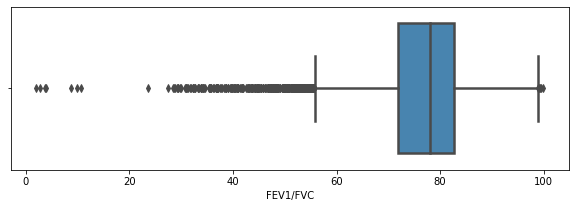

In [13]:
plt.figure(figsize=(10,3))
sns.boxplot(x="fev1_fvc_pre", data=PFT, linewidth=2.5, palette="Blues_d")
plt.xlabel('FEV1/FVC')
plt.show() # fev1/fvc inferior a 0.10? erro ou real?

In [14]:
PFT=PFT.loc[PFT.fev1_fvc_pre>10] #outlier detectado na skewness, revisto no boxplot

In [15]:
PFT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 1 to 9016
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 8140 non-null   int64  
 1   sex                 8140 non-null   object 
 2   date                8140 non-null   object 
 3   height              8140 non-null   float64
 4   tlc                 8140 non-null   float64
 5   tlco                6429 non-null   float64
 6   fev1_pos            3507 non-null   float64
 7   fev1_pre            8140 non-null   float64
 8   fev1_fvc_pos        3506 non-null   float64
 9   fev1_fvc_pre        8140 non-null   float64
 10  fvc_pos             3507 non-null   float64
 11  fvc_pre             8140 non-null   float64
 12  weight              8140 non-null   float64
 13  vc                  8140 non-null   float64
 14  Bronchodilator      3507 non-null   object 
 15  rv                  8140 non-null   float64
 16  Ep    

Quais os erros:

In [16]:
errors = PFT.errors.unique() #a transformar em z scores, erros tipo apareciam nesta variável, a maioria relacionada com idade (>80 anos)
print (errors)

[nan]


In [17]:
PFT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 1 to 9016
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 8140 non-null   int64  
 1   sex                 8140 non-null   object 
 2   date                8140 non-null   object 
 3   height              8140 non-null   float64
 4   tlc                 8140 non-null   float64
 5   tlco                6429 non-null   float64
 6   fev1_pos            3507 non-null   float64
 7   fev1_pre            8140 non-null   float64
 8   fev1_fvc_pos        3506 non-null   float64
 9   fev1_fvc_pre        8140 non-null   float64
 10  fvc_pos             3507 non-null   float64
 11  fvc_pre             8140 non-null   float64
 12  weight              8140 non-null   float64
 13  vc                  8140 non-null   float64
 14  Bronchodilator      3507 non-null   object 
 15  rv                  8140 non-null   float64
 16  Ep    

##### Remover colunas que não são necessárias:

In [18]:
PFT = PFT.drop(['Bronchodilator','Ep','errors','fev1_pre_lln','fev1_pre_uln','fvc_pre_lln','fvc_pre_uln','fev1fvc_pre_lln','fev1fvc_pre_uln','tlco_lln','tlco_uln','tlc_lln','tlc_uln','rv_lln','rv_uln','rvtlc_lln','rvtlc_uln','vc_lln','vc_uln'], axis=1)

Skewness and Kurtosis

In [19]:
PFT.skew(axis=0, skipna=True).sort_values(ascending=True)

fev1fvc_pos_z        -1.519954
fev1fvc_pre_pp       -1.410972
fev1_pos_z           -1.382777
tlco_z               -1.351611
fev1_fvc_pre         -1.264860
fev1_fvc_pos         -0.807184
tlco_pp              -0.803869
fev1fvc_pre_z        -0.576851
fev1_pre_pp          -0.522088
fvc_pos_z            -0.362592
age                  -0.311418
fvc_pre_z            -0.307755
tlc_z                -0.295434
fev1_pre_z           -0.279579
fvc_pre_pp           -0.243116
vc_z                 -0.148176
vc_pp                -0.119408
tlc_pp               -0.022243
height                0.141906
vc_predicted          0.273242
tlc_predicted         0.344322
fev1_pre              0.348214
tlc                   0.384303
rv_z                  0.386075
fvc_predicted         0.392266
rvtlc_predicted       0.393654
fvc_pos_pp            0.399599
fev1_pre_predicted    0.401302
tlco                  0.415892
fvc_pre               0.417863
fev1_pos              0.427946
vc                    0.430110
rv_predi

In [20]:
#skew de -4 no fev/fvc, que no boxplot aparentam ser outliers...selecionei fev1/fvc acima de 10%

Se a skewness da amostra é entre -0.5 e 0.5, a amostra é praticamente simétrica;
Se for entre - 1 e -.5, é moderadamente assimétrica (positiva), se for <-1 é muito assimétrica;
Se for entre 0.5 e 1, é moderadamente assimétrica (negativa), se for >1 é muito assimétrica;

Assim sendo, as variáveis RV/TLC, TLC, FEV1 e FVC pré BD não são marcadamente assimétricas, ao contrário de RV. 

In [21]:
PFT.kurtosis(axis=0,skipna=True).sort_values(ascending=True)

fvc_pos_pp           -1.688748
fev1_pos_pp          -1.559349
rvtlc_predicted      -0.984970
tlc_predicted        -0.871202
age                  -0.846886
vc_predicted         -0.633034
tlco_pp              -0.619844
fvc_predicted        -0.459941
height               -0.422199
fev1_pre_predicted   -0.383592
tlco_predicted       -0.321522
rv_predicted         -0.176652
fev1_pre             -0.089452
tlc                  -0.086468
fvc_pre              -0.045827
fev1_pos             -0.027310
vc                    0.001651
fvc_pos               0.027052
tlco                  0.152021
rv_tlc                0.267738
fev1_pre_z            0.394739
fev1fvc_pre_dicted    0.616380
fev1_pre_pp           0.793040
fvc_pre_pp            0.824310
tlc_pp                0.827944
fvc_pre_z             0.941139
weight                0.969790
tlc_z                 1.082860
fev1_fvc_pos          1.128021
fev1fvc_pre_z         1.169452
rv_z                  1.296521
rvtlc_z               1.550685
vc_z    

Kurtosis calculada pelo método Fisher (>0 lepticúrtica, 0 normal, <0 platicúrtica.

In [22]:
#necessátio transformar (log) alguma variável?

##### Missing values (n e percentagem):

In [23]:
print(PFT.isnull().sum())
(PFT.isnull().sum()/(len(PFT)))*100

age                      0
sex                      0
date                     0
height                   0
tlc                      0
tlco                  1711
fev1_pos              4633
fev1_pre                 0
fev1_fvc_pos          4634
fev1_fvc_pre             0
fvc_pos               4633
fvc_pre                  0
weight                   0
vc                       0
rv                       0
NHC                      0
fev1_pre_predicted       0
fev1_pre_z               0
fev1_pre_pp              0
fvc_predicted            0
fvc_pre_z                0
fvc_pre_pp               0
fev1fvc_pre_dicted       0
fev1fvc_pre_z            0
fev1fvc_pre_pp           0
tlco_predicted           0
tlco_z                   0
tlco_pp                  0
tlc_predicted            0
tlc_z                    0
tlc_pp                   0
rv_predicted             0
rv_z                     0
rv_pp                    0
rvtlc_predicted          0
rvtlc_z                  0
rvtlc_pp                 0
v

age                    0.000000
sex                    0.000000
date                   0.000000
height                 0.000000
tlc                    0.000000
tlco                  21.019656
fev1_pos              56.916462
fev1_pre               0.000000
fev1_fvc_pos          56.928747
fev1_fvc_pre           0.000000
fvc_pos               56.916462
fvc_pre                0.000000
weight                 0.000000
vc                     0.000000
rv                     0.000000
NHC                    0.000000
fev1_pre_predicted     0.000000
fev1_pre_z             0.000000
fev1_pre_pp            0.000000
fvc_predicted          0.000000
fvc_pre_z              0.000000
fvc_pre_pp             0.000000
fev1fvc_pre_dicted     0.000000
fev1fvc_pre_z          0.000000
fev1fvc_pre_pp         0.000000
tlco_predicted         0.000000
tlco_z                 0.000000
tlco_pp                0.000000
tlc_predicted          0.000000
tlc_z                  0.000000
tlc_pp                 0.000000
rv_predi

Todos os valores da espirometria basal e de volumes estáticos estão presentes, nenhum exemplo será removido. 

In [24]:
# missing values em parâmetros pós BD e dlco - justificável

### Análise Univariada

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240B050D670>,
      dtype=object)

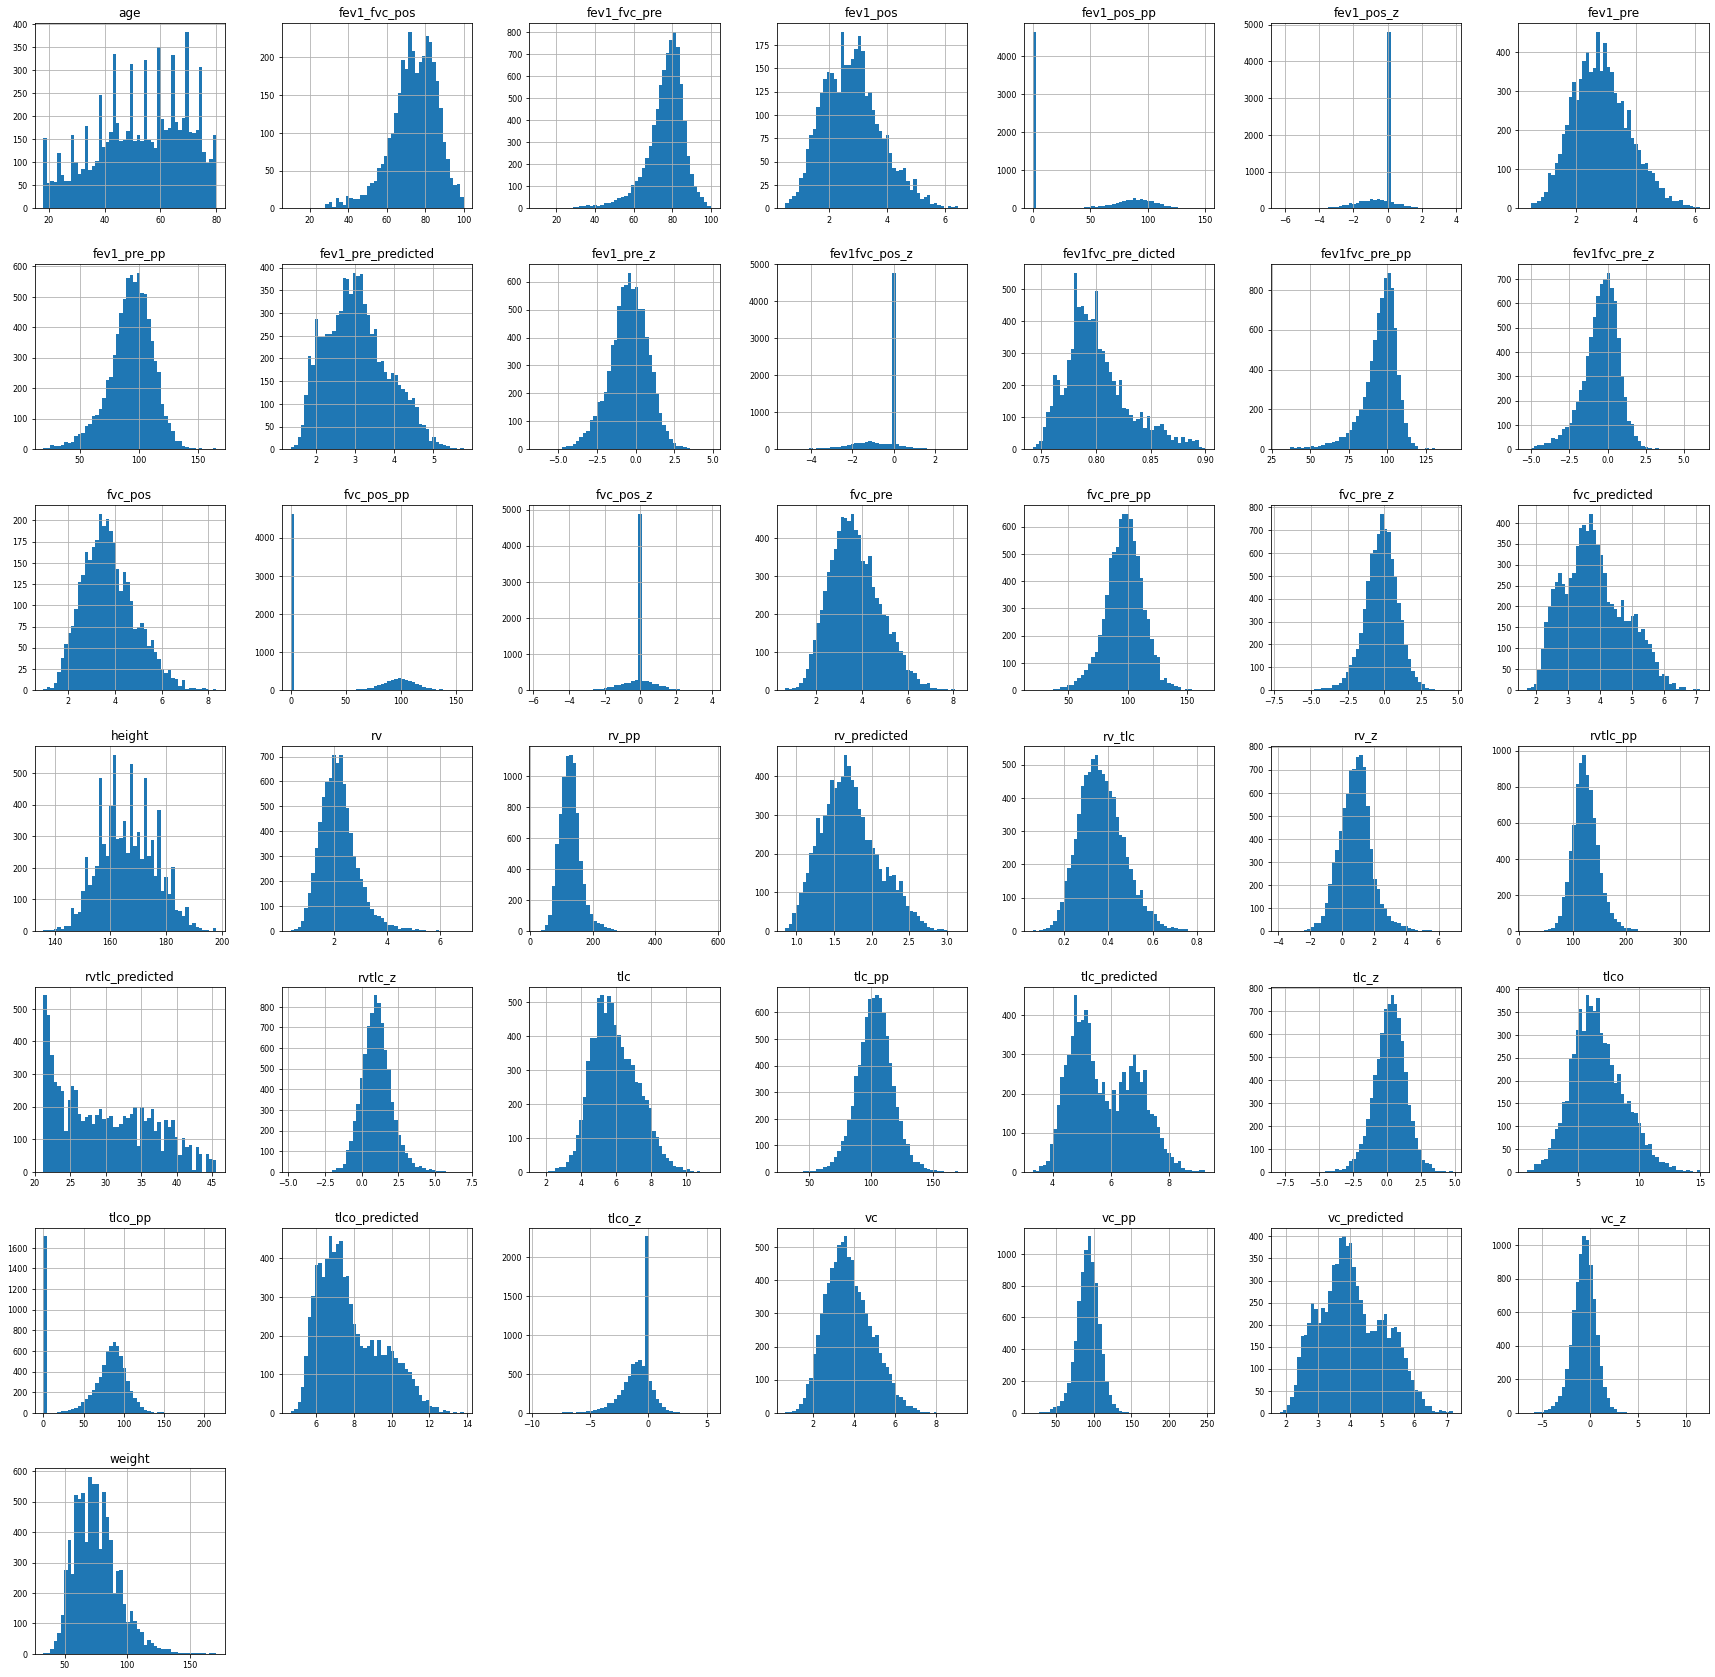

In [25]:
#Histograma
PFT.hist(figsize=(30,30), bins=50, xlabelsize=8, ylabelsize=8)

In [26]:
pip install -U seaborn

Requirement already up-to-date: seaborn in c:\users\marco\anaconda3\lib\site-packages (0.12.0)
Note: you may need to restart the kernel to use updated packages.


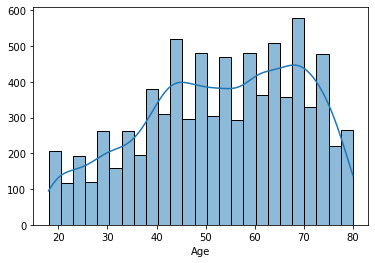

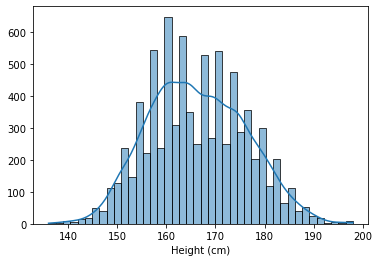

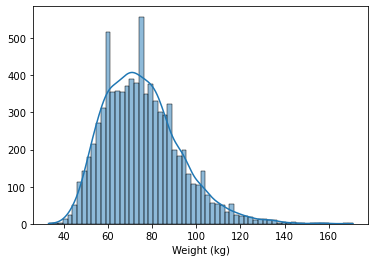

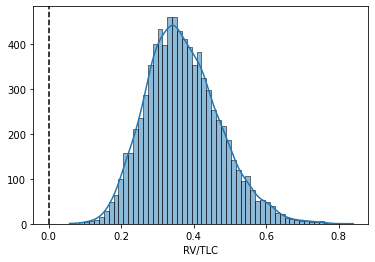

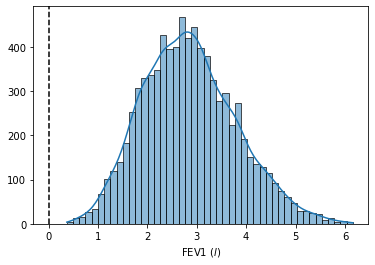

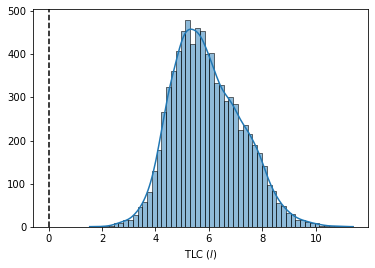

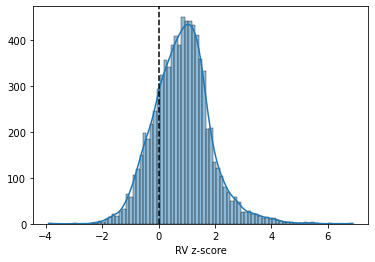

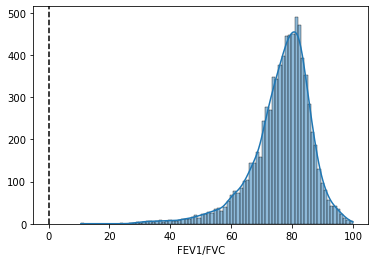

In [27]:
figsize=(5,5)
sns.histplot(data=PFT, x="age", kde=True)
plt.xlabel('Age')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="height", kde=True)
plt.xlabel('Height (cm)')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="weight", kde=True)
plt.xlabel('Weight (kg)')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="rv_tlc", kde=True)
plt.axvline(0,color="k",linestyle="--")
#linha vertical
plt.xlabel('RV/TLC')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="fev1_pre", kde=True)
plt.axvline(0,color="k",linestyle="--")
plt.xlabel('FEV1 ($l$)')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="tlc", kde=True)
plt.axvline(0,color="k",linestyle="--")
plt.xlabel('TLC ($l$)')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="rv_z", kde=True)
plt.axvline(0,color="k",linestyle="--")
plt.xlabel('RV z-score')
plt.ylabel('')
plt.show()
figsize=(5,5)
sns.histplot(data=PFT, x="fev1_fvc_pre", kde=True)
plt.axvline(0,color="k",linestyle="--")
#linha vertical
plt.xlabel('FEV1/FVC')
plt.ylabel('')
plt.show()

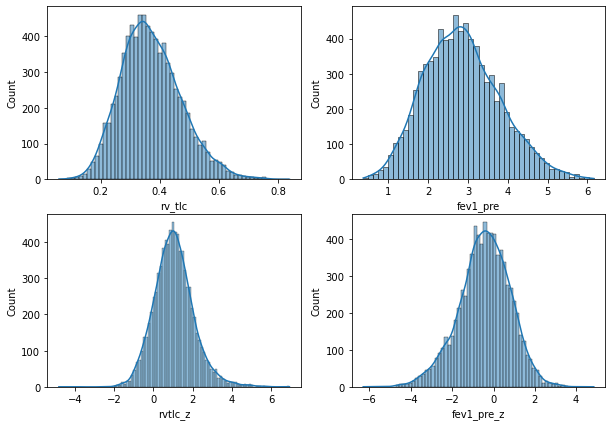

In [28]:
fig, axs = plt.subplots(2,2,figsize=(10,7))

sns.histplot(data=PFT, x="rv_tlc", kde=True , ax=axs[0,0])
sns.histplot(data=PFT, x="rvtlc_z", kde=True, ax=axs[1,0])
sns.histplot(data=PFT, x="fev1_pre", kde=True, ax=axs[0,1])
sns.histplot(data=PFT, x="fev1_pre_z", kde=True, ax=axs[1,1])


plt.show()

Amostra não aparenta ter nenhum parâmetro com necessidade de ser transformado (log) - tudo aparentemente com distribuição normal

In [29]:
PFT.describe()

age       height          tlc         tlco     fev1_pos  \
count  8140.000000  8140.000000  8140.000000  6429.000000  3507.000000   
mean     53.021867   166.276351     5.930853     6.599641     2.795317   
std      16.046238     9.841430     1.294597     2.137800     1.000044   
min      18.000000   136.000000     1.540000     0.800000     0.471408   
25%      41.750000   159.000000     4.990000     5.100000     2.043702   
50%      54.000000   166.000000     5.780000     6.390000     2.741624   
75%      67.000000   174.000000     6.810000     7.930000     3.399590   
max      80.000000   198.000000    11.390000    15.000000     6.471840   

          fev1_pre  fev1_fvc_pos  fev1_fvc_pre     fvc_pos      fvc_pre  \
count  8140.000000   3506.000000   8140.000000  3507.00000  8140.000000   
mean      2.853243     73.985005     76.465043     3.74860     3.715489   
std       0.947369     12.149031      9.897603     1.12114     1.107298   
min       0.370000     10.060000     10.620000     0.93000     0.650000   
25%       2.170000     67.360000     71.970000     2.92000     2.920000   
50%       2.790000     75.005000     78.110000     3.63000     3.610000   
75%       3.460000     82.760000     82.790000     4.46000     4.430000   
max       6.160000     99.750000     99.960000     8.34000     8.210000   

            weight           vc           rv  fev1_pre_predicted   fev1_pre_z  \
count  8140.000000  8140.000000  8140.000000         8140.000000  8140.000000   
mean     75.441912     3.756337     2.174516            3.049255    -0.438228   
std      17.307089     1.107783     0.705430            0.786773     1.249513   
min      33.000000     0.650000     0.340000            1.345000    -6.302000   
25%      63.000000     2.950000     1.700000            2.458000    -1.184000   
50%      74.000000     3.640000     2.100000            2.990500    -0.393000   
75%      85.000000     4.460000     2.530000            3.547000     0.414000   
max     171.000000     9.080000     6.910000            5.770000     4.851000   

       fev1_pre_pp  fvc_predicted    fvc_pre_z   fvc_pre_pp  \
count  8140.000000    8140.000000  8140.000000  8140.000000   
mean     93.225008       3.819956    -0.203945    97.179593   
std      18.378988       0.949406     1.104940    15.793114   
min      19.213000       1.727000    -7.098000    19.807000   
25%      83.025500       3.118000    -0.893000    87.419500   
50%      94.685000       3.721000    -0.163000    97.760000   
75%     105.591000       4.457250     0.530000   107.433250   
max     165.238000       7.114000     4.634000   165.516000   

       fev1fvc_pre_dicted  fev1fvc_pre_z  fev1fvc_pre_pp  tlco_predicted  \
count         8140.000000    8140.000000     8140.000000     8140.000000   
mean             0.800792      -0.425590       95.449045        7.800315   
std              0.028804       1.173644       11.489592        1.652099   
min              0.742000      -5.249000       30.337000        4.649000   
25%              0.781000      -1.070000       90.565000        6.537000   
50%              0.796000      -0.298000       97.545000        7.391000   
75%              0.815000       0.357000      102.866000        8.944000   
max              0.900000       6.036000      142.509000       13.813000   

            tlco_z      tlco_pp  tlc_predicted        tlc_z       tlc_pp  \
count  8140.000000  8140.000000    8140.000000  8140.000000  8140.000000   
mean     -0.887116    66.792238       5.772140     0.226543   103.212297   
std       1.316111    38.251436       1.101495     1.171593    14.637370   
min      -9.493000     0.000000       3.308000    -7.903000    30.516000   
25%      -1.529000    51.291500       4.860000    -0.487250    94.063750   
50%      -0.591000    80.308000       5.548000     0.273500   103.384000   
75%       0.000000    93.312250       6.711000     0.984000   112.439000   
max       5.374000   214.770000       9.264000     4.870000   170.795000   

    

In [30]:
PFT.sex.value_counts()

F    4556
M    3584
Name: sex, dtype: int64

55,97% de mulheres, 44,03% de homens

### Análise Bivariada

In [31]:
PFT_zscores = PFT.drop(['NHC', 'weight','fev1_pos_pp','fvc_pos_pp','rv_pp','vc_pp','rvtlc_pp','tlco_pp','tlc_pp','fev1_pre_pp','fvc_pre_pp','fev1fvc_pre_pp','fev1_pre','fev1_pre_predicted','fvc_pre','fvc_predicted','fev1_fvc_pre','fev1fvc_pre_dicted','tlco','tlco_predicted','tlc','tlc_predicted','rv','rv_predicted','rv_tlc','rvtlc_predicted','vc','vc_predicted','fev1_fvc_pos','fev1_pos','fvc_pos'], axis=1)

In [32]:
PFT_zscores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 1 to 9016
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            8140 non-null   int64  
 1   sex            8140 non-null   object 
 2   date           8140 non-null   object 
 3   height         8140 non-null   float64
 4   fev1_pre_z     8140 non-null   float64
 5   fvc_pre_z      8140 non-null   float64
 6   fev1fvc_pre_z  8140 non-null   float64
 7   tlco_z         8140 non-null   float64
 8   tlc_z          8140 non-null   float64
 9   rv_z           8140 non-null   float64
 10  rvtlc_z        8140 non-null   float64
 11  vc_z           8140 non-null   float64
 12  fev1_pos_z     8140 non-null   float64
 13  fvc_pos_z      8140 non-null   float64
 14  fev1fvc_pos_z  8140 non-null   float64
dtypes: float64(12), int64(1), object(2)
memory usage: 1.3+ MB


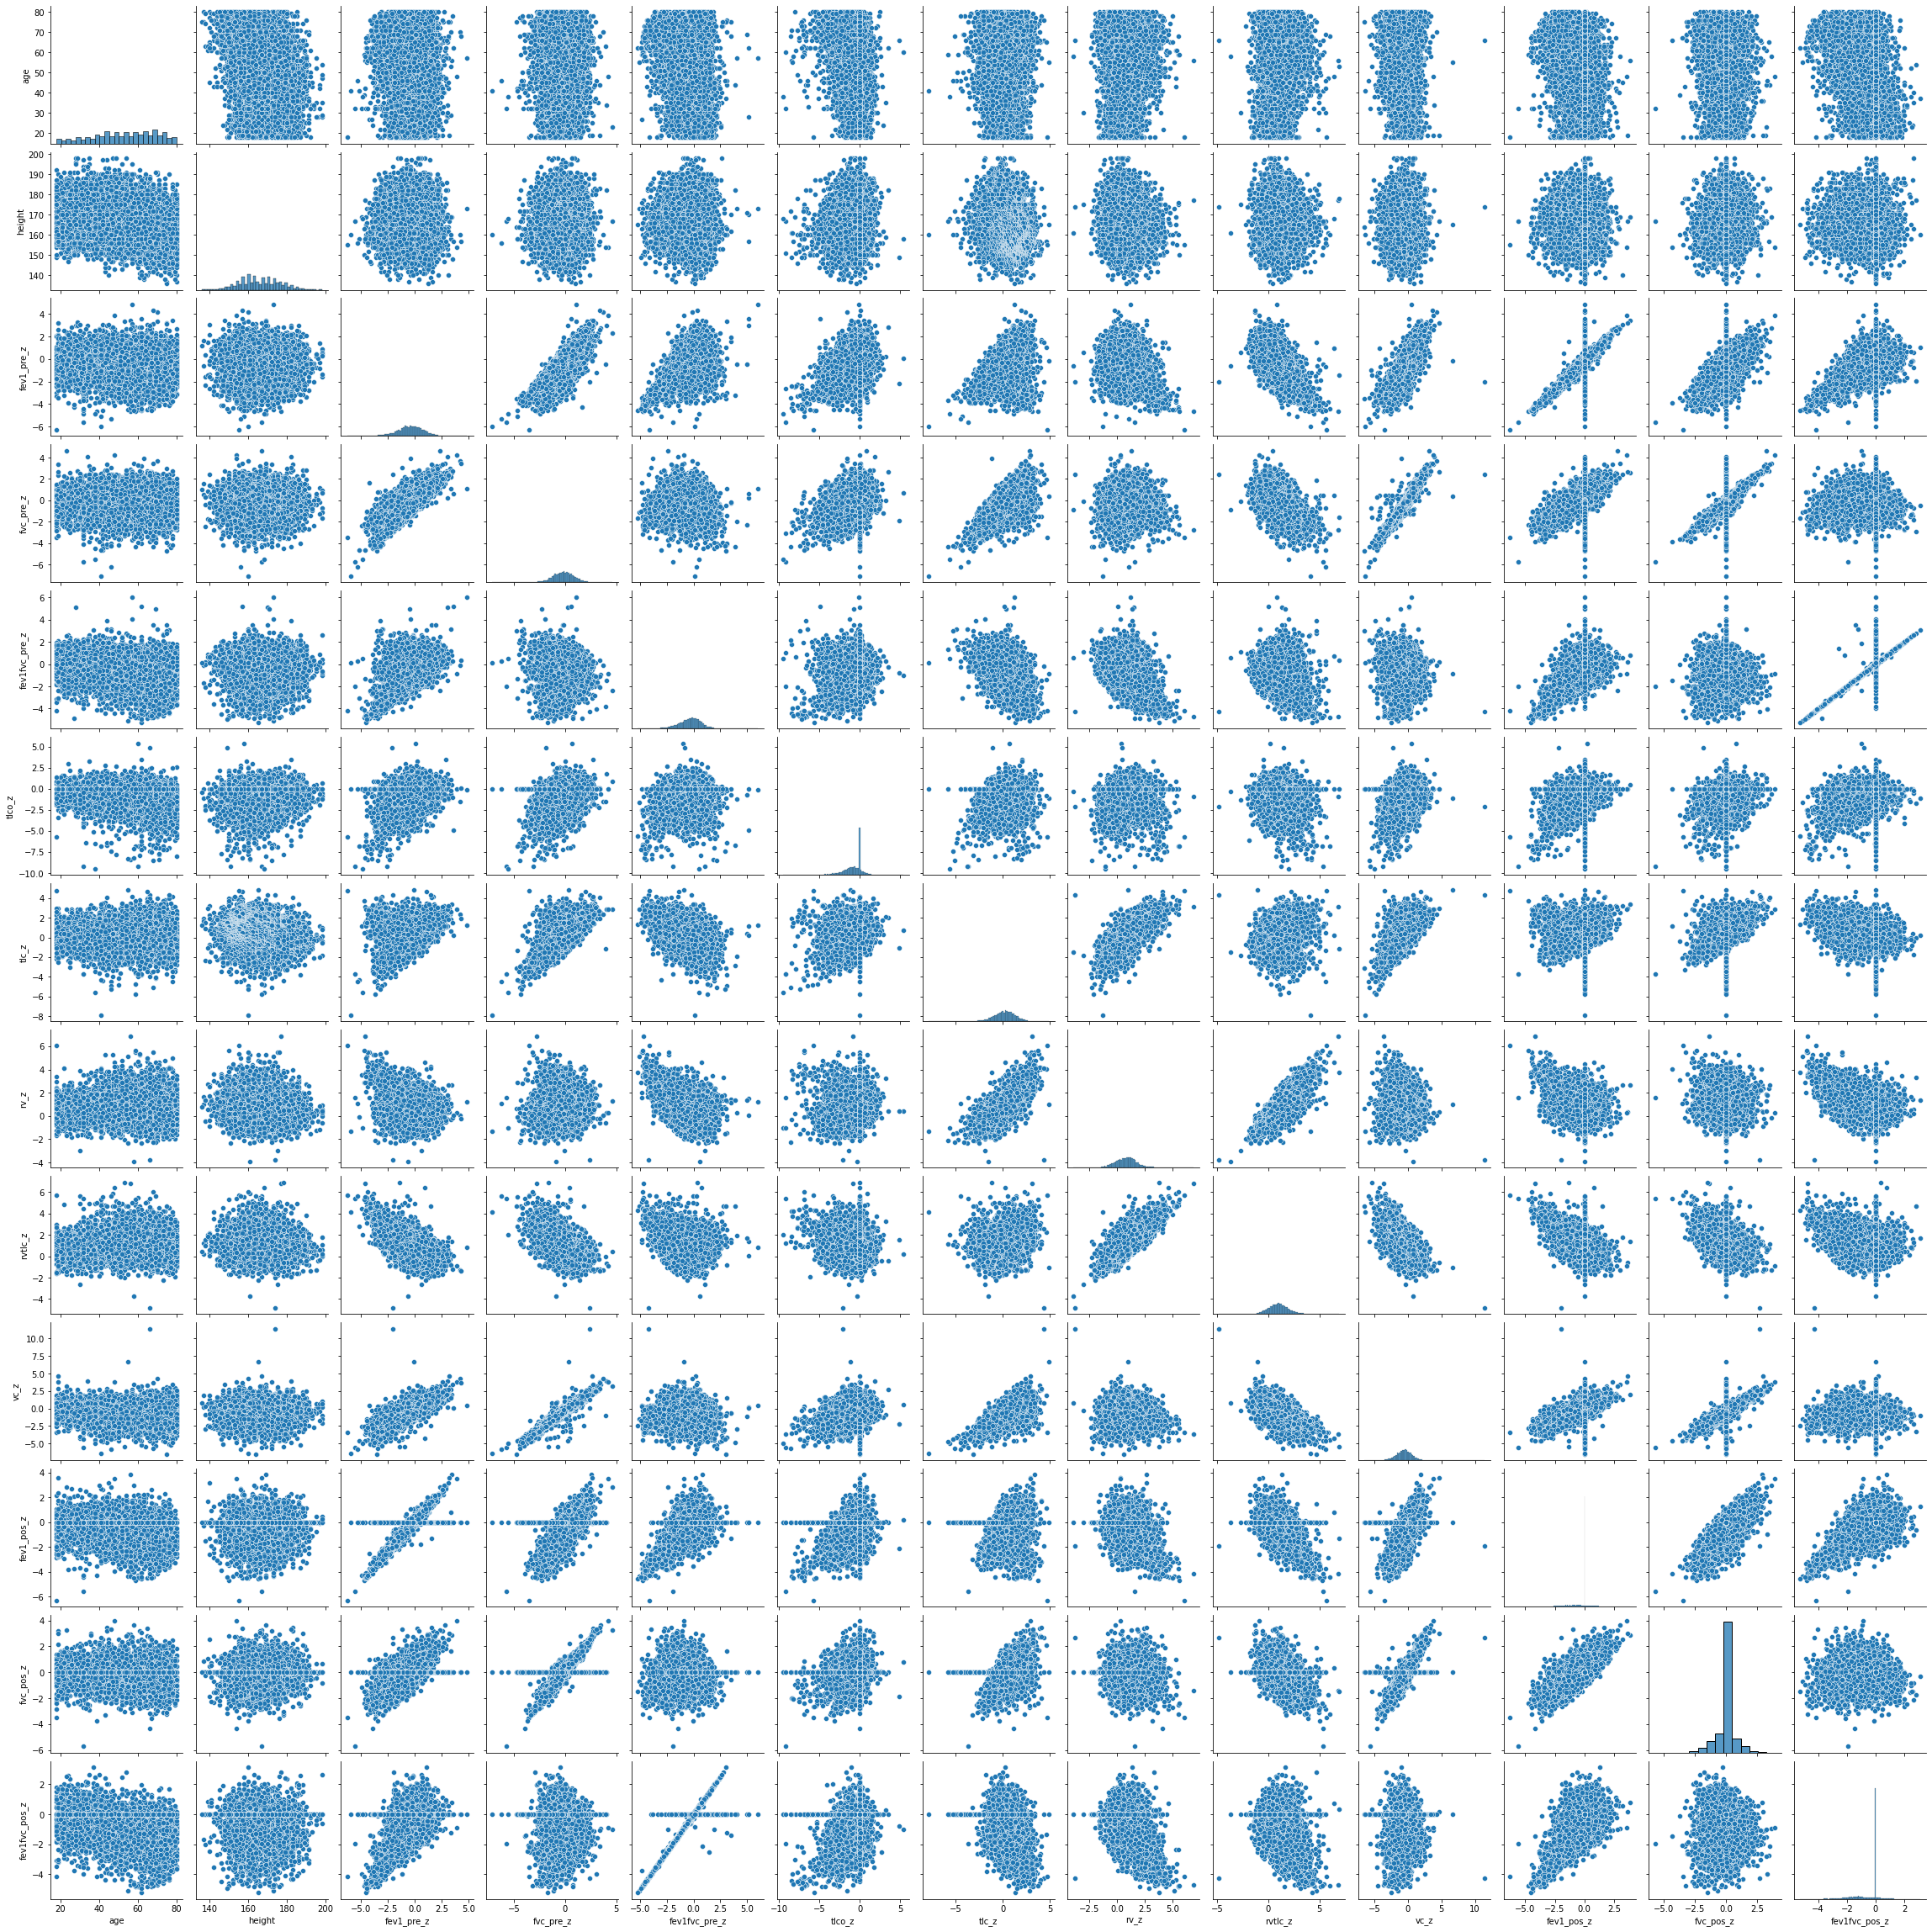

In [33]:
sns.pairplot(data=PFT_zscores)
plt.show()

Aparentemente sem outliers severos, como expectável vários valores 0 nos parâmtros pós bronchodilatador e TLCO

In [34]:
PFT_zscores_pre = PFT_zscores.drop(['age', 'height', 'fev1_pos_z','fvc_pos_z','fev1fvc_pos_z'], axis=1)

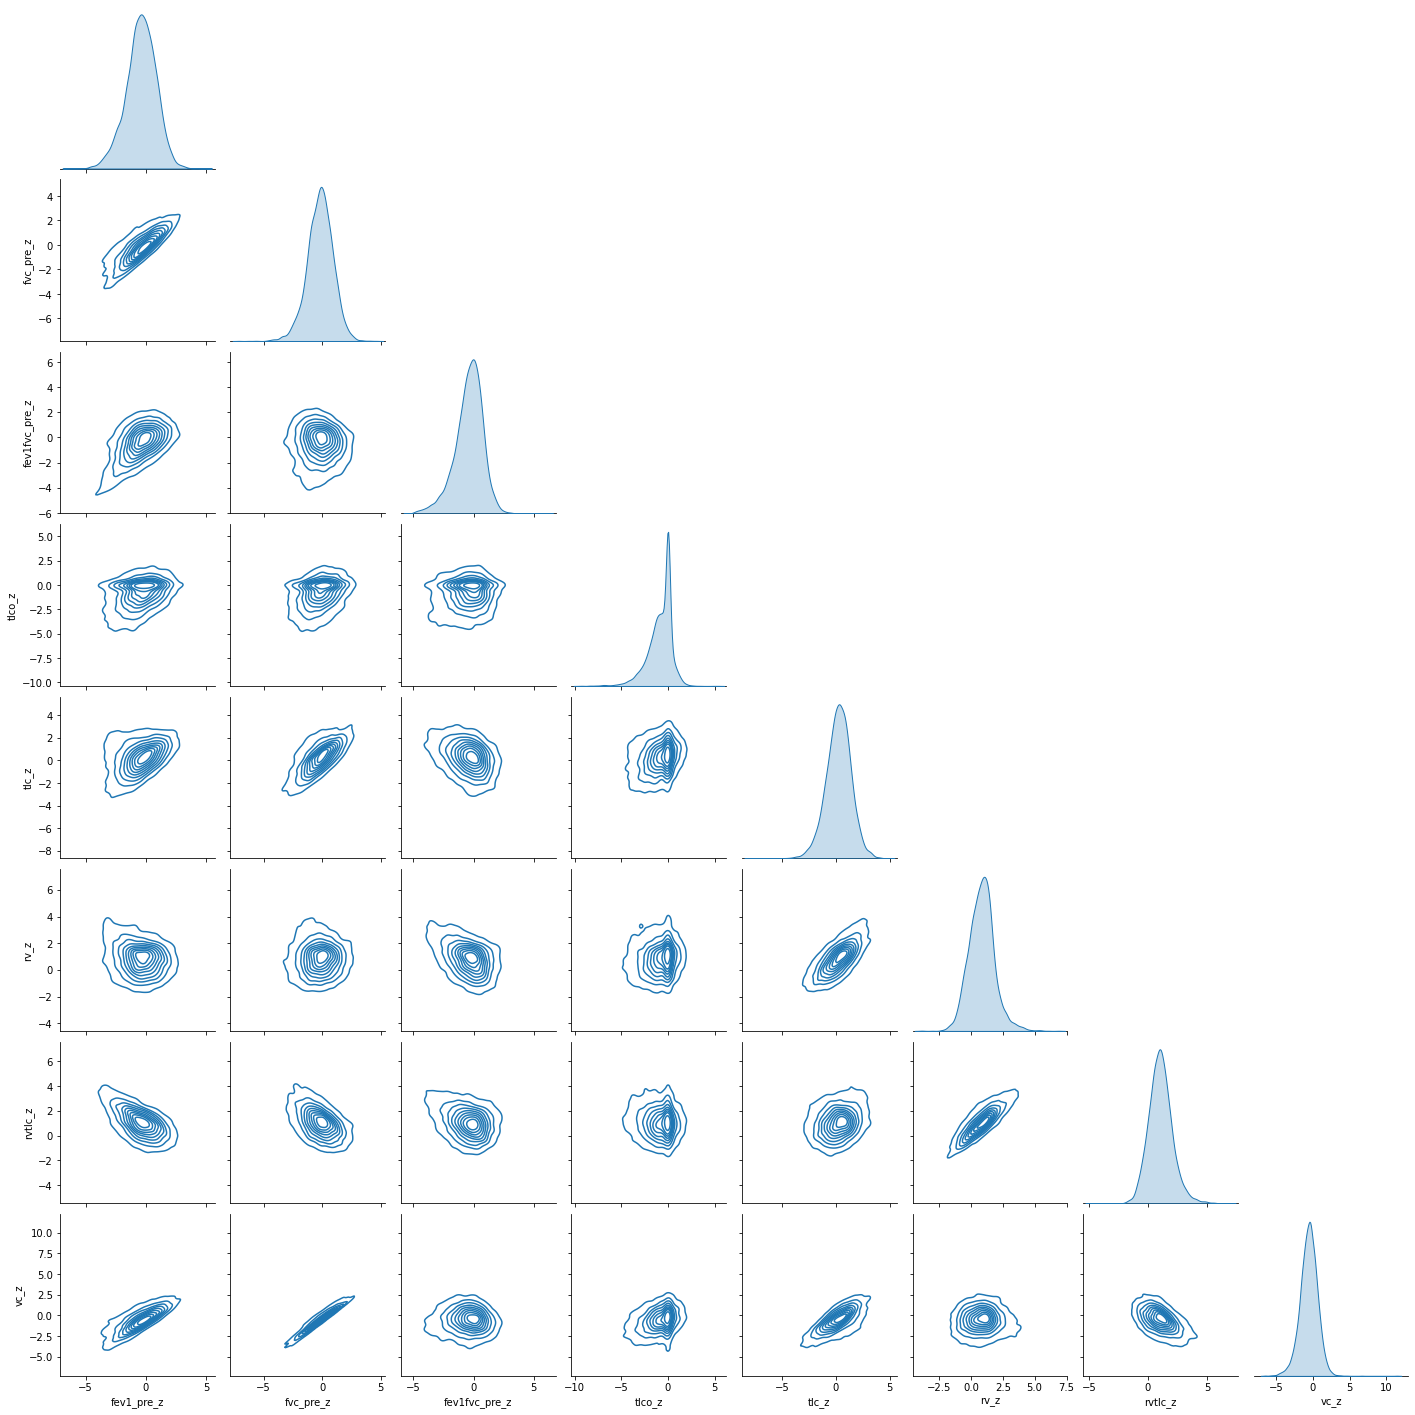

In [35]:
sns.pairplot(data=PFT_zscores_pre, kind="kde", corner=True)
plt.show()

In [36]:
PFT_essentials=PFT[["sex","fev1_pre","fvc_pre","fev1_fvc_pre","tlco","tlc","rv","rv_tlc","vc"]]# criação de subset

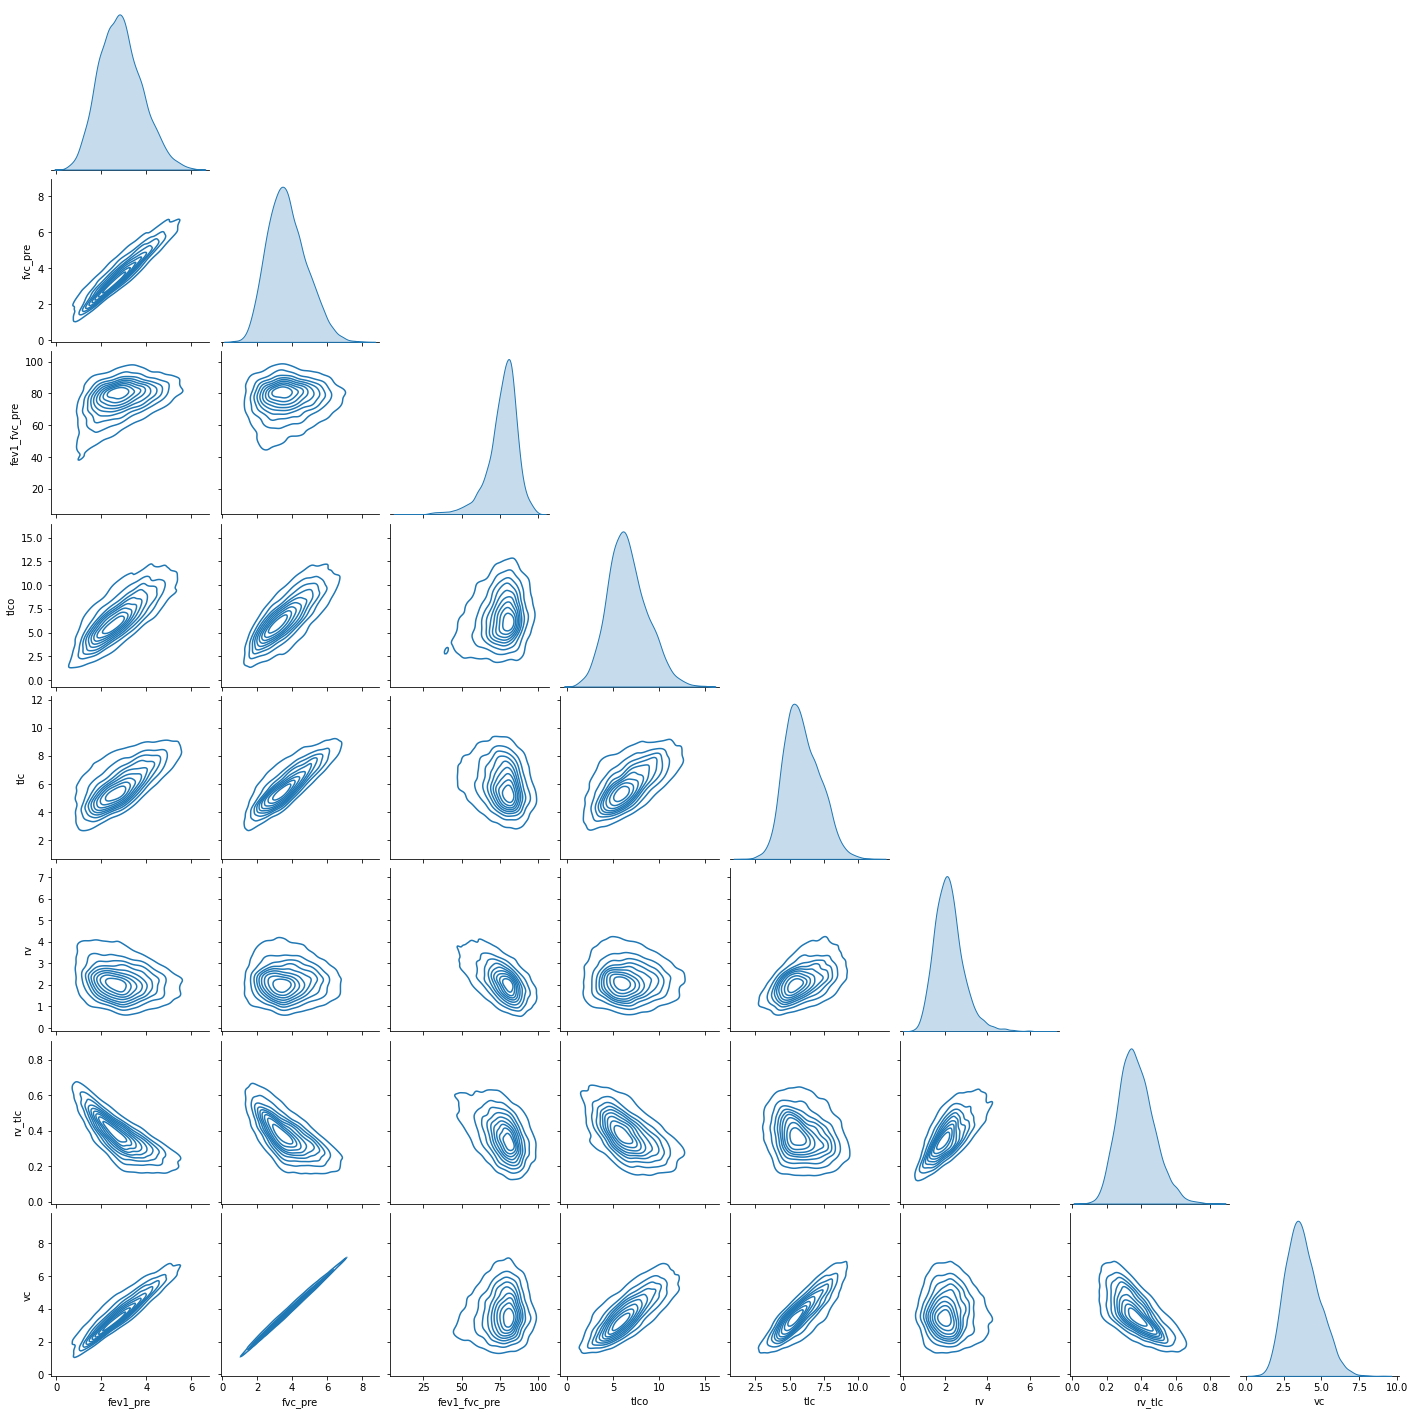

In [37]:
sns.pairplot(data=PFT_essentials, kind="kde", corner=True)
plt.show()

In [38]:
#colocar pela mesma ordem os valores "brutos" e os z scores

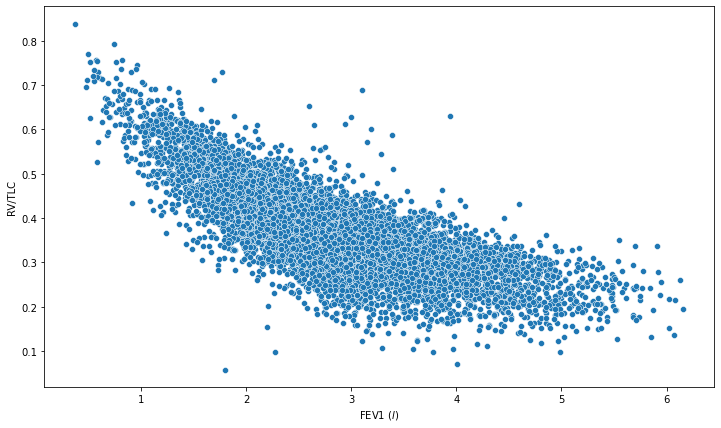

In [39]:
plt.figure(figsize=(12,7))
sns.scatterplot(data = PFT, x = "fev1_pre", y = "rv_tlc")
plt.xlabel('FEV1 ($l$)')
plt.ylabel('RV/TLC')
plt.show()

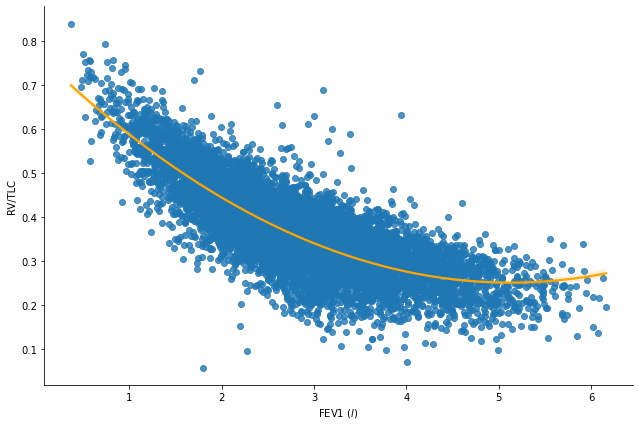

In [40]:
sns.lmplot(data = PFT, x = "fev1_pre", y = "rv_tlc", order=2, height=6, aspect=1.5, line_kws={'color': 'orange'})
plt.xlabel('FEV1 ($l$)')
plt.ylabel('RV/TLC')
plt.show()

In [41]:
#relação fev1/fvc aparenta mais uma relação polinomial de grau 2 do que puramente linear

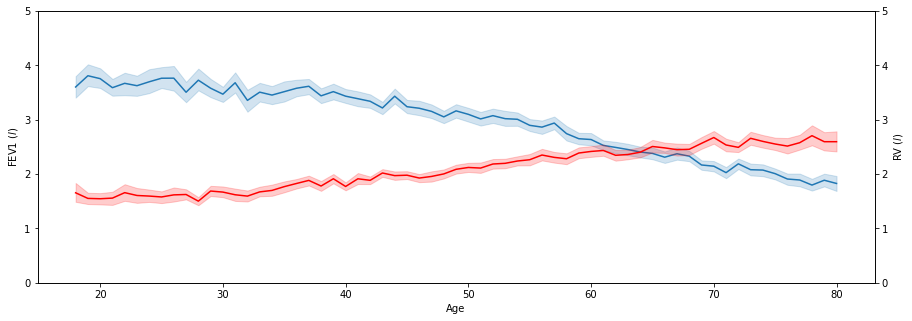

In [42]:
plt.figure(figsize=(15,5))
sns.lineplot(data = PFT, x="age", y = "fev1_pre", )
plt.ylabel('FEV1 ($l$)')
plt.xlabel('Age')
plt.ylim(0,5)
ax2=plt.twinx()
sns.lineplot(data = PFT, x = "age", y = "rv", ax=ax2,  color="red")
plt.ylabel('RV ($l$)')
plt.ylim(0,5)
plt.show()

In [43]:
#Aumento de RV/TLC proporcional à diminuição do FEV1 (R=-0.78)

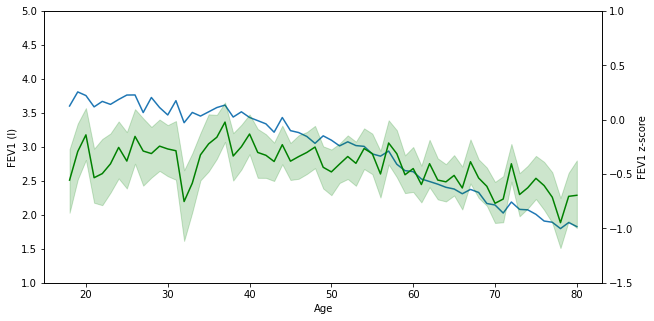

In [131]:
plt.figure(figsize=(10,5))
sns.lineplot(data = PFT, x="age", y = "fev1_pre",  errorbar=None)
plt.ylabel('FEV1 (l)')
plt.xlabel('Age')
plt.ylim(1,5)
ax2=plt.twinx()
sns.lineplot(data = PFT, x = "age", y = "fev1_pre_z", ax=ax2, color="green")
plt.ylabel('FEV1 z-score')
plt.ylim(-1.5,1)
plt.show()

In [132]:
#Relação FEV1 com z score FEV1 com a idade

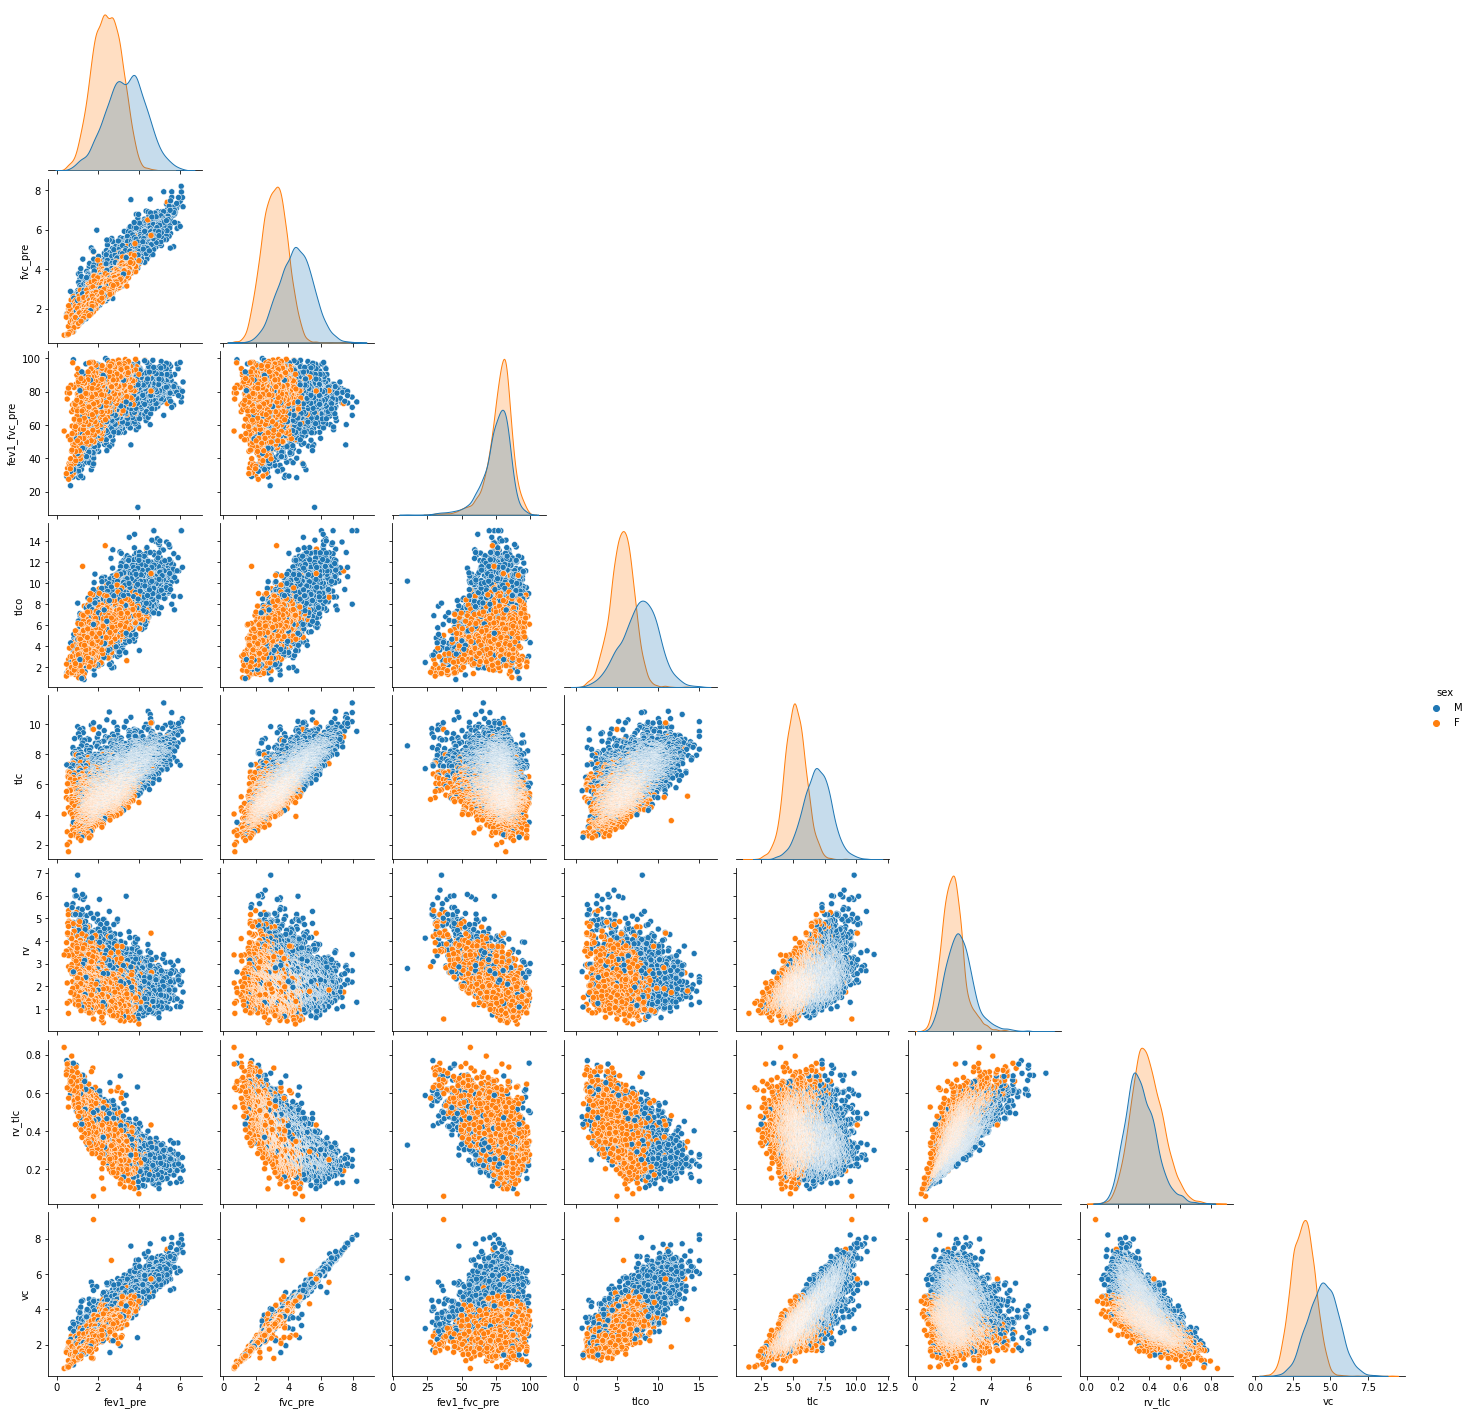

In [46]:
sns.pairplot(data=PFT_essentials, hue="sex", corner=True)
plt.show()

Diferenças entre os sexos em todos os parâmetros com excepção das relações FEV1/FVC e RV/TLC (homens são em média mais altos e, logo, apresentam volumes pulmonares maiores

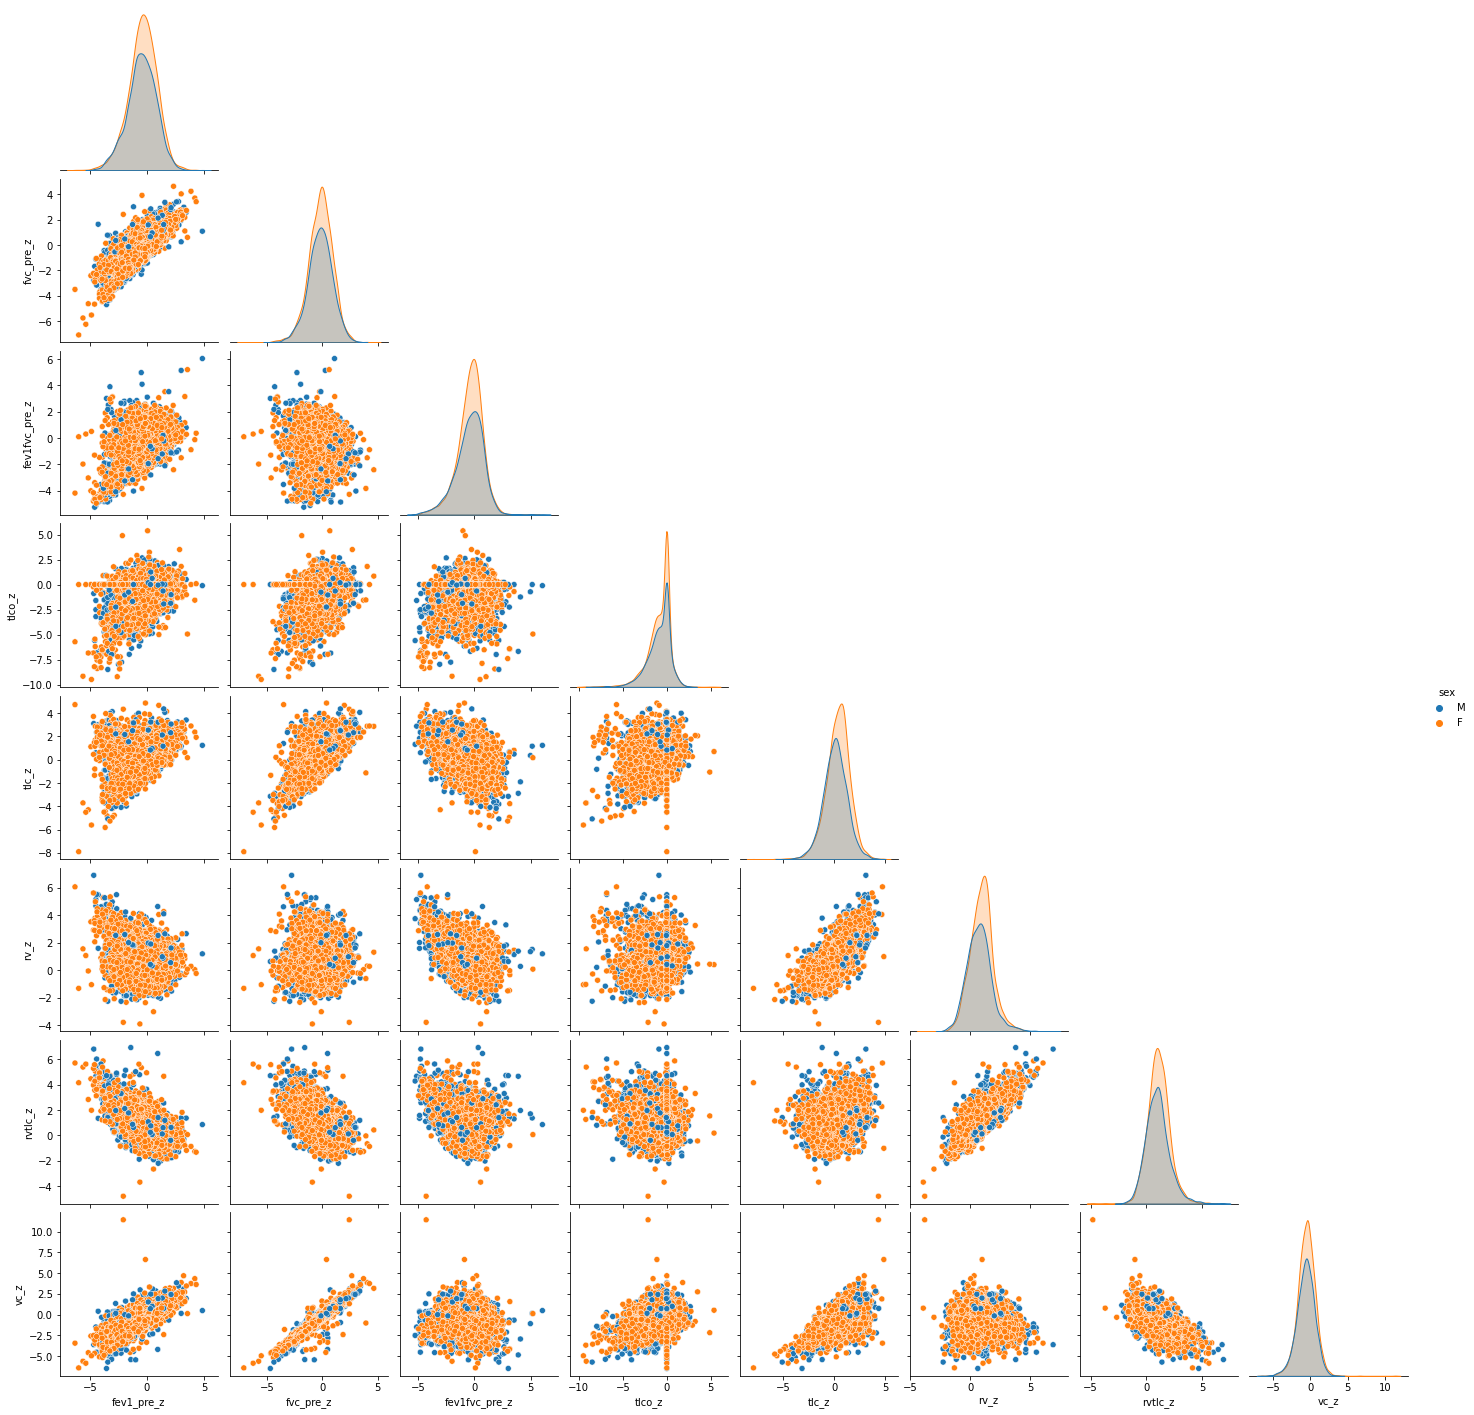

In [47]:
sns.pairplot(data=PFT_zscores_pre, hue="sex", corner=True)
plt.show()

Quando se observa com a distância em relação ao "normal", diferenças entre os sexos diminuem ou desaparecem

### Análise Multivariada

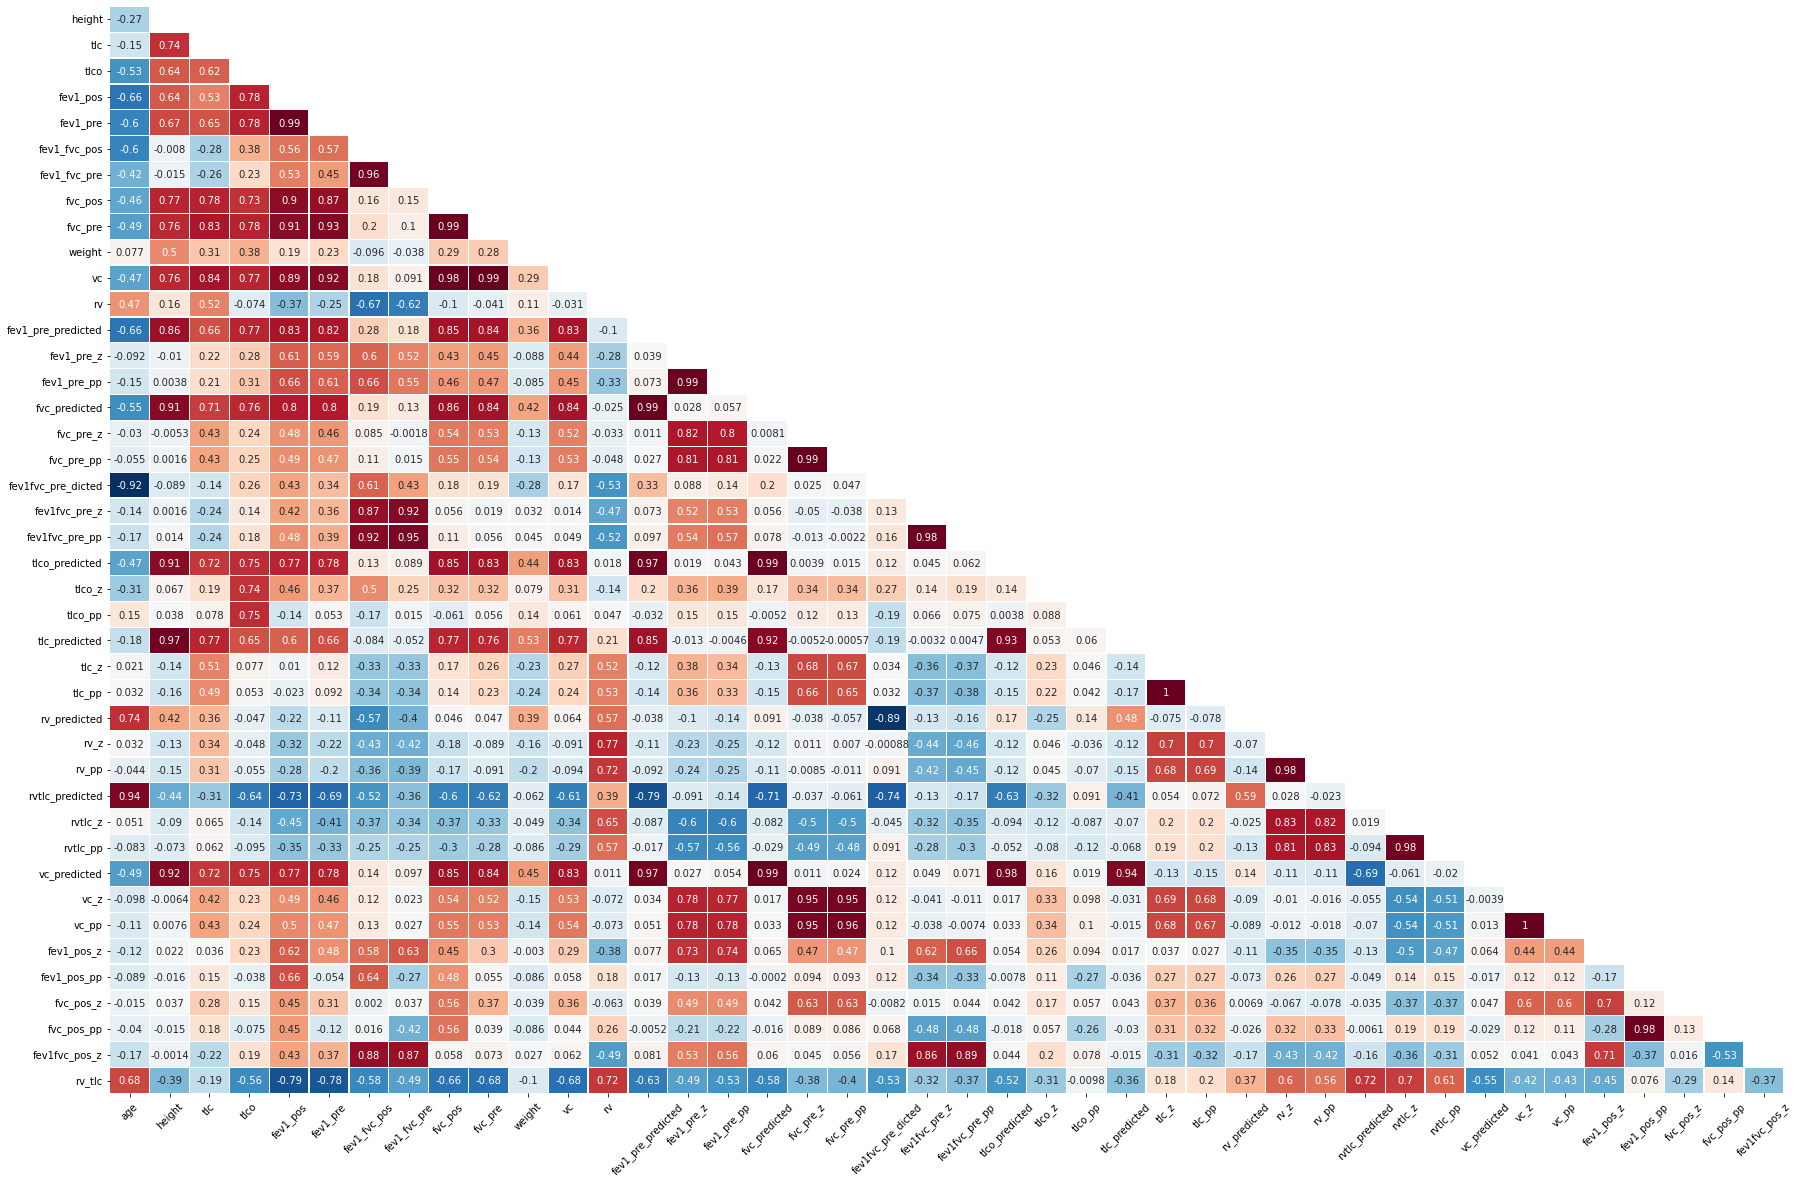

In [48]:
plt.figure(figsize=(30,20))
#mask vai servir para fazer em triângulo
mask=np.triu(np.ones_like(PFT.corr(),dtype=np.bool))
#adjust mask
mask=mask[1:,:-1]
corr=PFT.corr().iloc[1:,:-1].copy()
#Cor divergente, pois R será de -1 a 1
cmap=sns.diverging_palette(240,10,as_cmap=True)
sns.heatmap(data=corr, mask=mask, linewidth=0.3, annot=True, cbar=False, cmap='RdBu_r')
#Rotação de cada linha
plt.xticks(rotation=45)
plt.show()

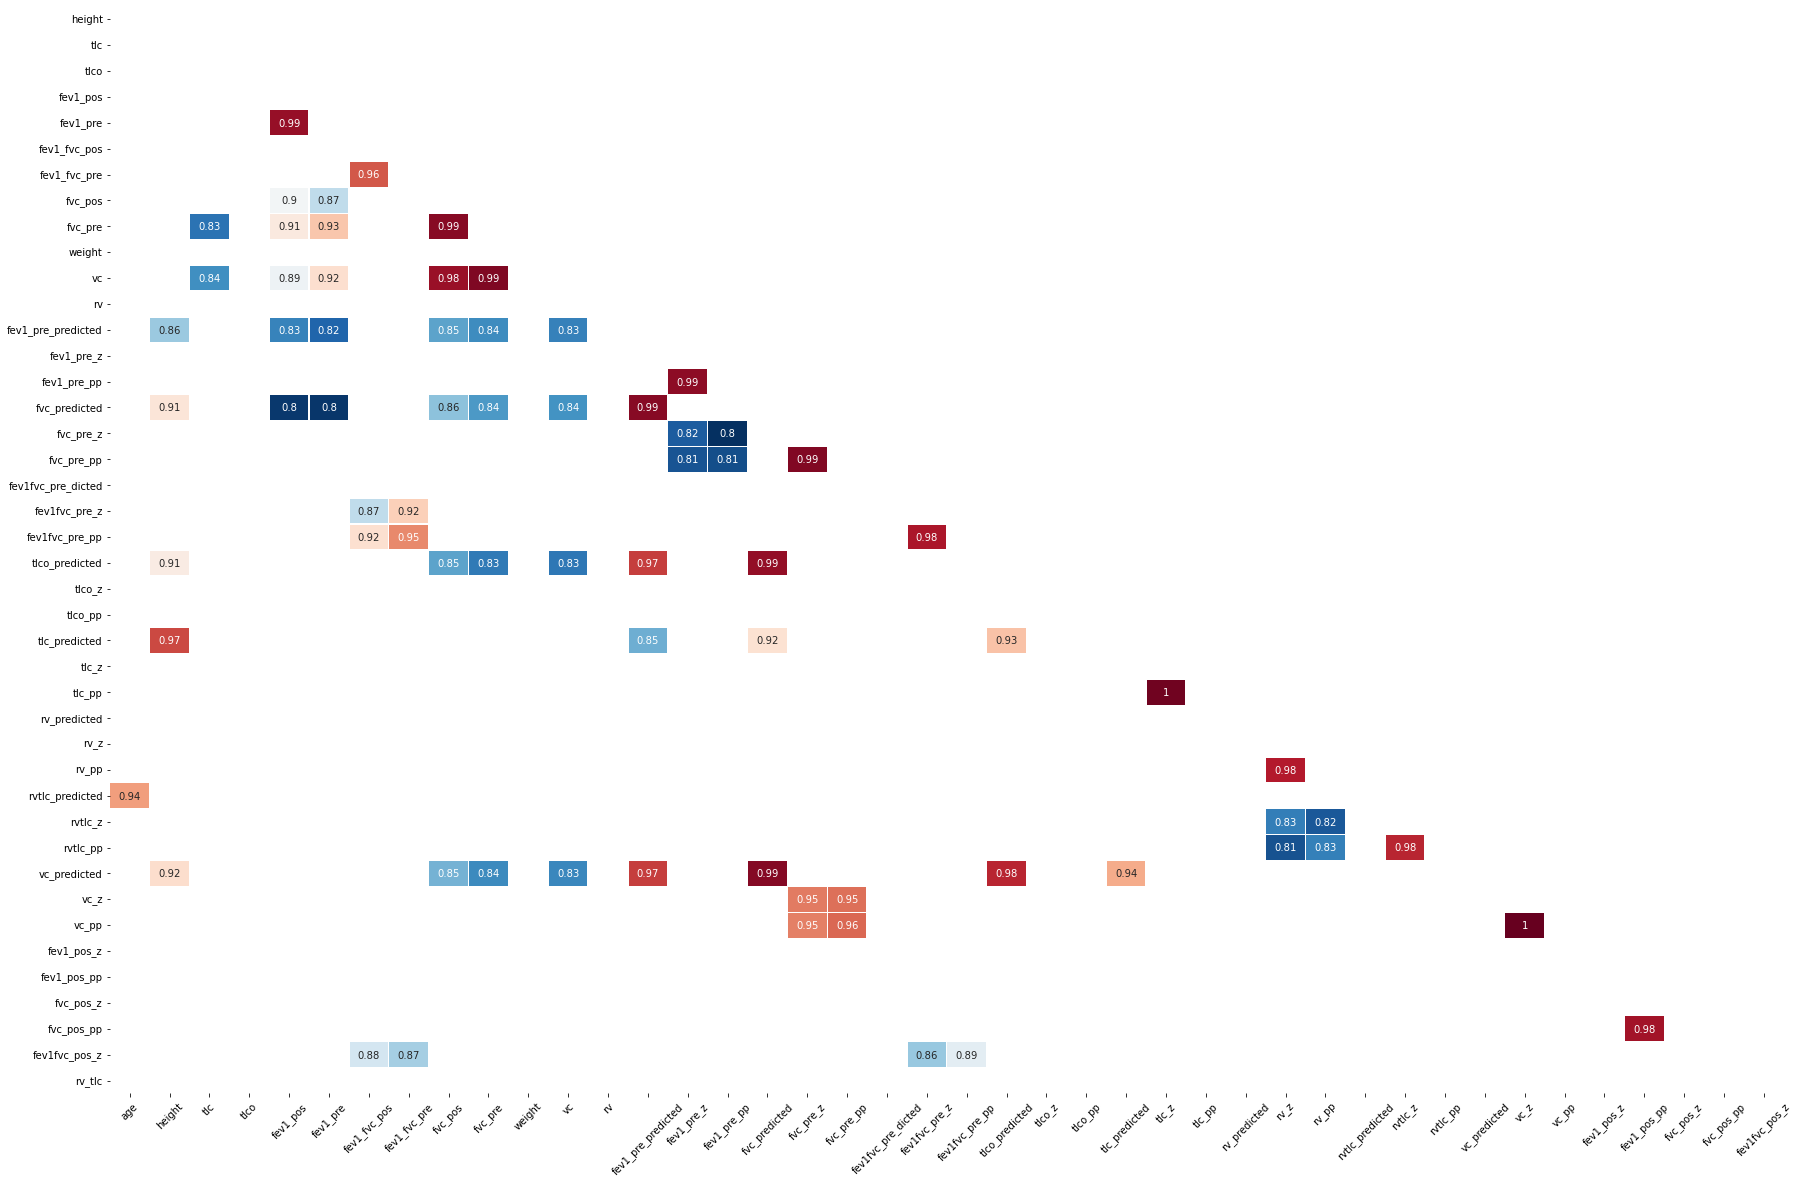

In [49]:
plt.figure(figsize=(30,20))
sns.heatmap(data=corr[corr>0.80], mask=mask, linewidth=0.3, annot=True, cbar=False, cmap='RdBu_r')
#Rotação de cada linha
plt.xticks(rotation=45)
plt.show()

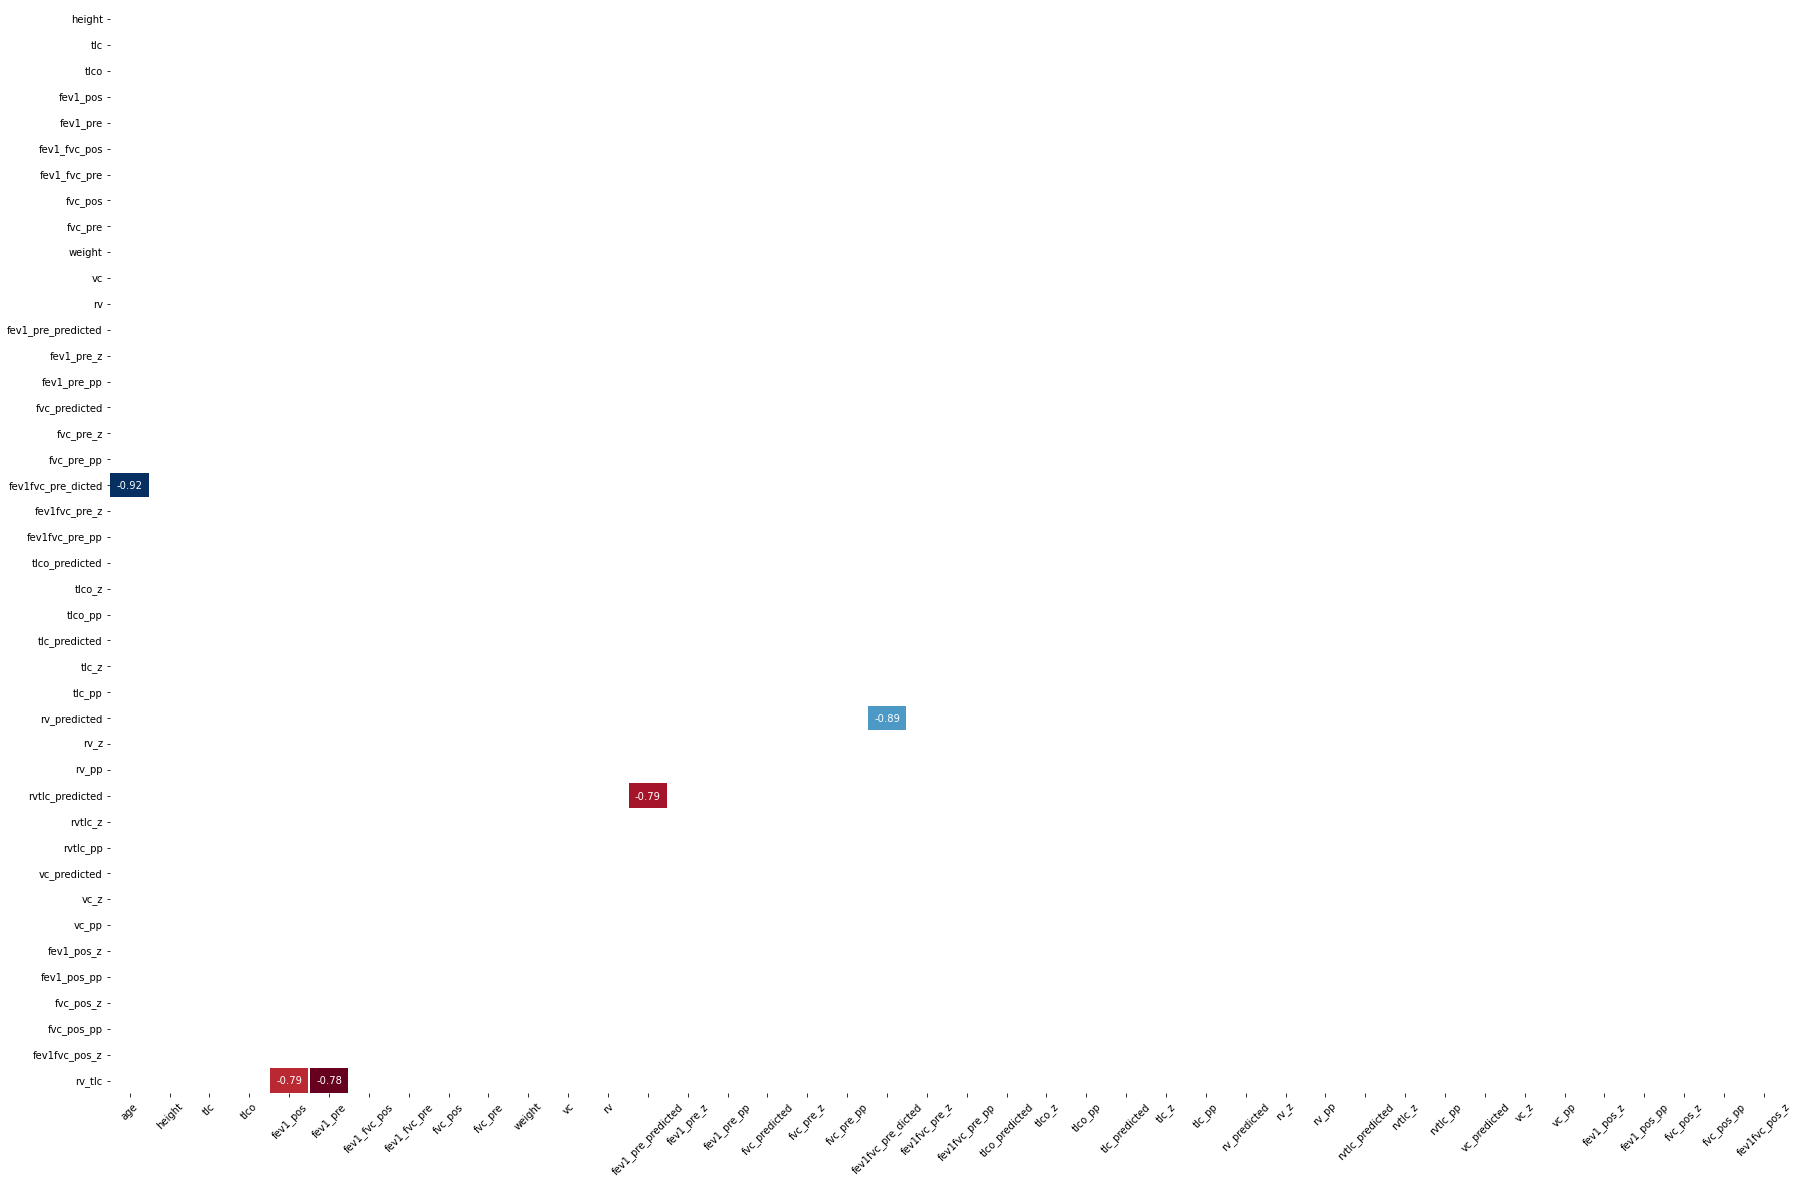

In [50]:
plt.figure(figsize=(30,20))
sns.heatmap(data=corr[corr<-0.75], mask=mask, linewidth=0.3, annot=True, cbar=False, cmap='RdBu_r')
#Rotação de cada linha
plt.xticks(rotation=45)
plt.show()

In [51]:
PFT.corr(method='pearson')['rv_tlc'].sort_values(ascending=True)

fev1_pos             -0.794522
fev1_pre             -0.777719
fvc_pre              -0.683859
vc                   -0.682114
fvc_pos              -0.662791
fev1_pre_predicted   -0.626632
fev1_fvc_pos         -0.583884
fvc_predicted        -0.575953
tlco                 -0.563175
vc_predicted         -0.550531
fev1_pre_pp          -0.534062
fev1fvc_pre_dicted   -0.525426
tlco_predicted       -0.523507
fev1_fvc_pre         -0.488039
fev1_pre_z           -0.487429
fev1_pos_z           -0.448570
vc_pp                -0.428031
vc_z                 -0.415873
fvc_pre_pp           -0.403465
height               -0.390445
fvc_pre_z            -0.380408
fev1fvc_pre_pp       -0.372180
fev1fvc_pos_z        -0.365848
tlc_predicted        -0.360684
fev1fvc_pre_z        -0.320317
tlco_z               -0.313628
fvc_pos_z            -0.291872
tlc                  -0.193005
weight               -0.099825
tlco_pp              -0.009835
fev1_pos_pp           0.075870
fvc_pos_pp            0.140668
tlc_z   

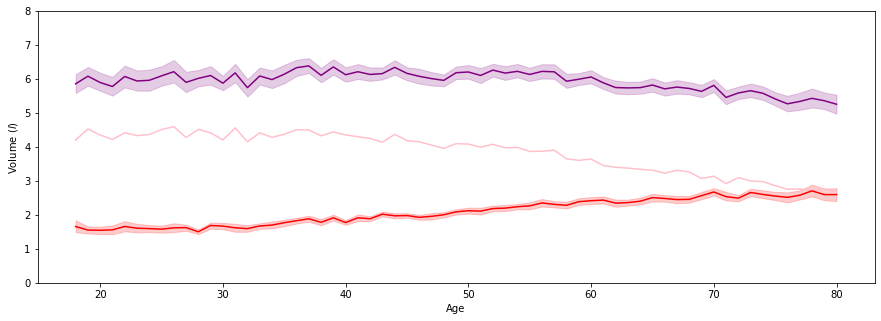

In [130]:
plt.figure(figsize=(15,5))
sns.lineplot(data = PFT, x="age", y = "tlc",  color="purple")
plt.ylabel('Volume ($l$)')
plt.ylim(0,8)
plt.xlabel('Age')
sns.lineplot(data = PFT, x="age", y = "vc", color="pink",  errorbar=None)
#ax2=plt.twinx()
sns.lineplot(data = PFT, x = "age", y = "rv",  color="red")
#plt.ylabel('RV ($l$)')
#plt.ylim(0,8)
plt.show()

TLC mantêm-se relativamente constante (com ligeira diminuição), enquanto que RV começa a aumentar por volta dos 35 anos. Na mesma linha de raciocínio, dado que TLC-RV=VC, aos 20 anos RV é 1/3 de TLC enquanto que VC representa 2/3, aos 80 anos a percentagem de TLC quer de RV, quer de VC são 50%.

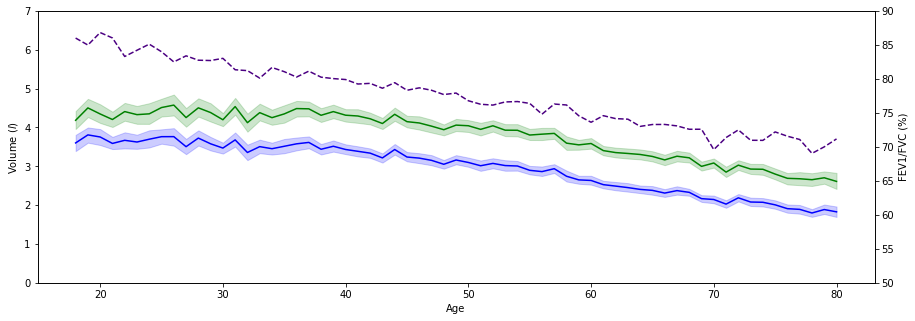

In [129]:
plt.figure(figsize=(15,5))
sns.lineplot(data = PFT, x="age", y = "fev1_pre",  color="blue")
plt.ylabel('Volume ($l$)')
plt.ylim(0,7)
plt.xlabel('Age')
sns.lineplot(data = PFT, x="age", y = "fvc_pre", color="green", )
ax2=plt.twinx()
sns.lineplot(data = PFT, x = "age", y = "fev1_fvc_pre", ax=ax2, errorbar=None,linestyle="--", color="indigo")
plt.ylabel('FEV1/FVC (%)')
plt.ylim(50,90)
plt.show()

FVC e FEV1 começam a decair por volta dos 35 anos, com FEV1 a decair a um ritmo ligeiramente maior, traduzindo-se numa diminuição de FEV1/FVC ao longo do tempo.

In [54]:
#remover grid, legenda nas linhas

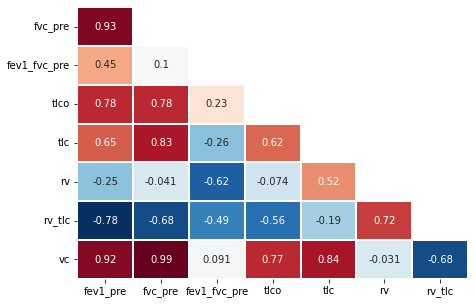

In [55]:
plt.figure(figsize=(7,5))
mask=np.triu(np.ones_like(PFT_essentials.corr(),dtype=np.bool))
mask=mask[1:,:-1]
corr=PFT_essentials.corr().iloc[1:,:-1].copy()
cmap=sns.diverging_palette(240,10,as_cmap=True)
sns.heatmap(data=corr, mask=mask, linewidth=1, annot=True, cbar=False, cmap='RdBu_r')
plt.show()

In [56]:
PFT_essentials.describe()

fev1_pre      fvc_pre  fev1_fvc_pre         tlco          tlc  \
count  8140.000000  8140.000000   8140.000000  6429.000000  8140.000000   
mean      2.853243     3.715489     76.465043     6.599641     5.930853   
std       0.947369     1.107298      9.897603     2.137800     1.294597   
min       0.370000     0.650000     10.620000     0.800000     1.540000   
25%       2.170000     2.920000     71.970000     5.100000     4.990000   
50%       2.790000     3.610000     78.110000     6.390000     5.780000   
75%       3.460000     4.430000     82.790000     7.930000     6.810000   
max       6.160000     8.210000     99.960000    15.000000    11.390000   

                rv       rv_tlc           vc  
count  8140.000000  8140.000000  8140.000000  
mean      2.174516     0.370925     3.756337  
std       0.705430     0.101613     1.107783  
min       0.340000     0.058091     0.650000  
25%       1.700000     0.299124     2.950000  
50%       2.100000     0.362055     3.640000  
75%       2.530000     0.434803     4.460000  
max       6.910000     0.839109     9.080000

In [57]:
PFT_essentials.skew(axis=0, skipna=True).sort_values(ascending=True)

fev1_fvc_pre   -1.264860
fev1_pre        0.348214
tlc             0.384303
tlco            0.415892
fvc_pre         0.417863
vc              0.430110
rv_tlc          0.453669
rv              1.029453
dtype: float64

In [58]:
PFT_essentials.kurtosis(axis=0,skipna=True).sort_values(ascending=True)

fev1_pre       -0.089452
tlc            -0.086468
fvc_pre        -0.045827
vc              0.001651
tlco            0.152021
rv_tlc          0.267738
rv              2.520161
fev1_fvc_pre    2.997943
dtype: float64

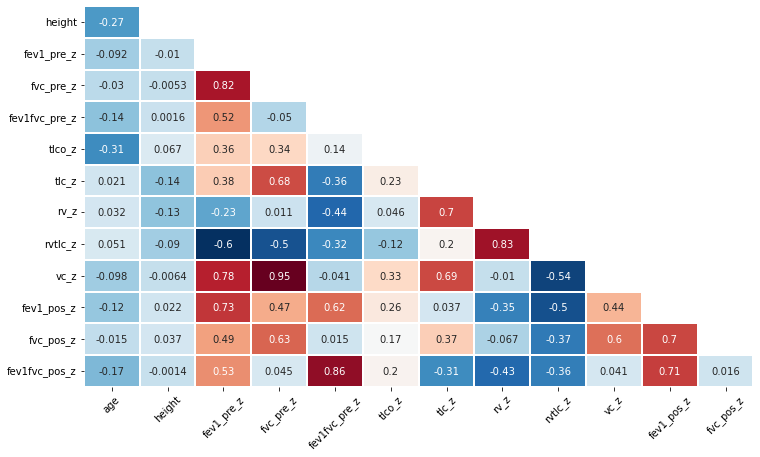

In [59]:
plt.figure(figsize=(12,7))
mask=np.triu(np.ones_like(PFT_zscores.corr(),dtype=np.bool))
mask=mask[1:,:-1]
corr=PFT_zscores.corr().iloc[1:,:-1].copy()
cmap=sns.diverging_palette(240,10,as_cmap=True)
sns.heatmap(data=corr, mask=mask, linewidth=1, annot=True, cbar=False, cmap='RdBu_r')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

In [60]:
PFT['BMI']=PFT['weight']/((PFT['height']*0.01)*(PFT['height']*0.01))# Criação de BMI

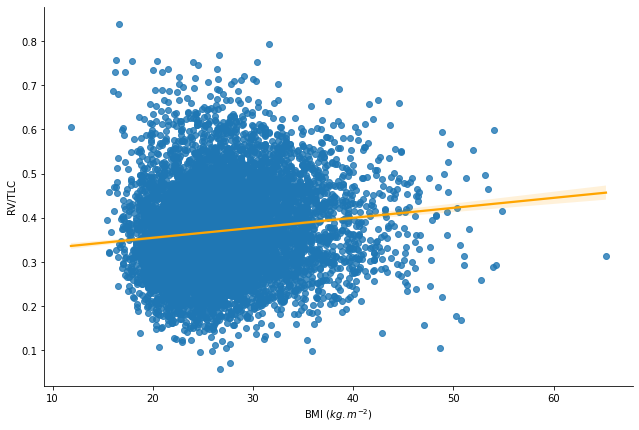

In [61]:
sns.lmplot(data = PFT, x = "BMI", y = "rv_tlc", height=6, aspect=1.5, line_kws={'color': 'orange'})
plt.xlabel('BMI ($kg.m^{-2}$)')
plt.ylabel('RV/TLC')
plt.show()

In [62]:
# Era expectável uma resposta de redução da RV/TLC com o aumento do IMC, no entanto doentes com enfisema evidente têm baixo peso e elevado RV/TLC

Categorias IMC

In [63]:
PFT['BMI_cat'] = np.nan
PFT.loc[(PFT['BMI'] < 18.5) , 'BMI_cat'] = 'Underweight'
PFT.loc[(PFT['BMI'] >= 18.5) & (PFT['BMI'] < 25), 'BMI_cat'] = 'Normal weight'
PFT.loc[(PFT['BMI'] >= 25) & (PFT['BMI'] < 30), 'BMI_cat'] = 'Overweight'
PFT.loc[(PFT['BMI'] >= 30) & (PFT['BMI'] < 35), 'BMI_cat'] = 'Obesity class I'
PFT.loc[(PFT['BMI'] >= 35) & (PFT['BMI'] < 40), 'BMI_cat'] = 'Obesity class II'
PFT.loc[(PFT['BMI'] >= 40), 'BMI_cat'] = 'Obesity class III'

Cat_BMI = PFT.BMI_cat.unique()
print(Cat_BMI)

['Overweight' 'Normal weight' 'Obesity class I' 'Obesity class II'
 'Underweight' 'Obesity class III']


In [64]:
PFT.BMI_cat.value_counts()

Normal weight        2959
Overweight           2881
Obesity class I      1480
Obesity class II      472
Obesity class III     208
Underweight           140
Name: BMI_cat, dtype: int64

Text(0.5, 0, '')

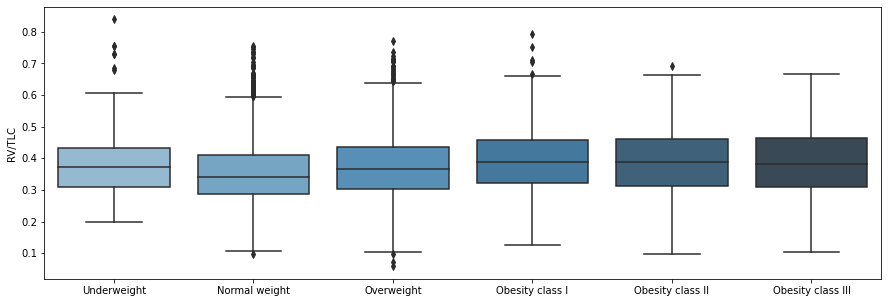

In [65]:
plt.figure(figsize=(15,5))
sns.boxplot(x="BMI_cat", y="rv_tlc", data=PFT, palette="Blues_d", order=["Underweight","Normal weight","Overweight", "Obesity class I","Obesity class II","Obesity class III"])
plt.ylabel('RV/TLC')
plt.xlabel('')

Text(0.5, 0, '')

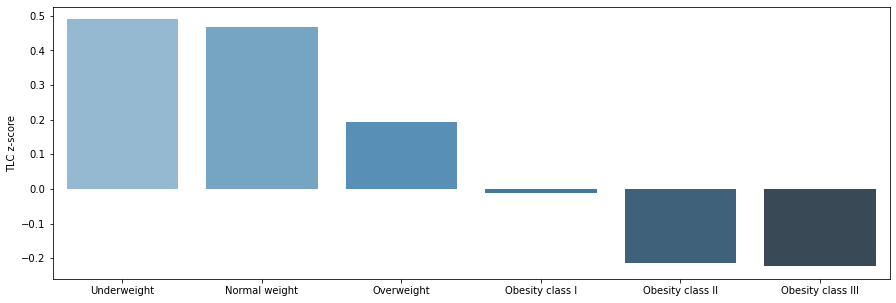

In [127]:
plt.figure(figsize=(15,5))
sns.barplot(x="BMI_cat", y="tlc_z", data=PFT,  errorbar=None, palette="Blues_d",order=["Underweight","Normal weight","Overweight", "Obesity class I","Obesity class II","Obesity class III"])
plt.ylabel('TLC z-score')
#ax2=plt.twinx()
#sns.lineplot(data = PFT, x = "BMI_cat", y = "tlc", ci=None, marker='o', ax=ax2, color="purple",hue_order=["Underweight","Normal weight","Overweight", "Obesity class I","Obesity class II","Obesity class III"])
plt.xlabel('')

Text(0.5, 0, '')

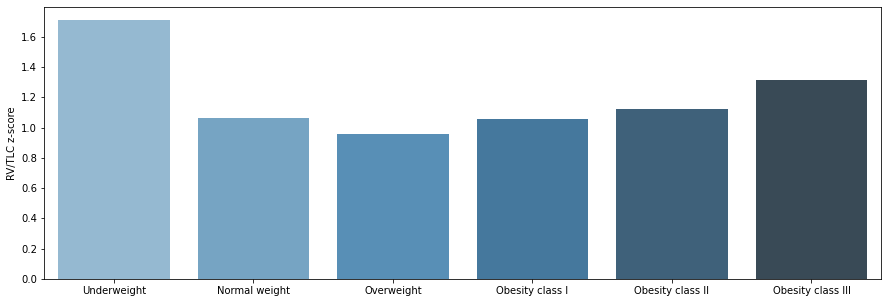

In [128]:
plt.figure(figsize=(15,5))
sns.barplot(x="BMI_cat", y="rvtlc_z",  errorbar=None, data=PFT, palette="Blues_d",order=["Underweight","Normal weight","Overweight", "Obesity class I","Obesity class II","Obesity class III"])
plt.ylabel('RV/TLC z-score')
plt.xlabel('')

Text(0.5, 0, '')

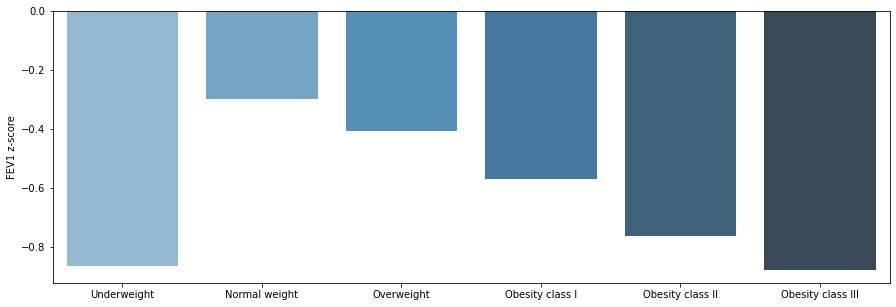

In [118]:
plt.figure(figsize=(15,5))
sns.barplot(x="BMI_cat", y="fev1_pre_z", errorbar=None, data=PFT, palette="Blues_d",order=["Underweight","Normal weight","Overweight", "Obesity class I","Obesity class II","Obesity class III"])
plt.ylabel('FEV1 z-score')
plt.xlabel('')

### Classificar a alteração ventilatória

Espirometria

In [69]:
PFT['Int_Spiro'] = np.nan
PFT.loc[(PFT['fev1fvc_pre_z'] < -1.645) & (PFT['fvc_pre_z'] >= -1.645), 'Int_Spiro'] = 'Obstruction'
PFT.loc[(PFT['fev1fvc_pre_z'] >= -1.645) & (PFT['fvc_pre_z'] < -1.645), 'Int_Spiro'] = 'Restriction'
PFT.loc[(PFT['fev1fvc_pre_z'] < -1.645) & (PFT['fvc_pre_z'] < -1.645), 'Int_Spiro'] = 'Mixed'
PFT.loc[(PFT['fev1fvc_pre_z'] >= -1.645) & (PFT['fvc_pre_z'] >= -1.645), 'Int_Spiro'] = 'Normal'

Alt_Spiro = PFT.Int_Spiro.unique()
print(Alt_Spiro)

['Obstruction' 'Normal' 'Restriction' 'Mixed']


In [133]:
PFT.Int_Spiro.value_counts()

Normal         6428
Obstruction     980
Restriction     584
Mixed           148
Name: Int_Spiro, dtype: int64

Pletismografia

In [147]:
PFT['Int_StaticVolumes'] = np.nan

PFT.loc[(PFT['tlc_z'] <= 1.645) & (PFT['tlc_z'] >= -1.645) & (PFT['rvtlc_z'] <= 1.645), 'Int_StaticVolumes'] = 'Normal static volumes'
PFT.loc[(PFT['tlc_z'] <= 1.645) & (PFT['tlc_z'] >= -1.645) & (PFT['rvtlc_z'] > 1.645) , 'Int_StaticVolumes'] = 'Air trapping'
PFT.loc[(PFT['tlc_z'] > 1.645) & (PFT['rvtlc_z'] > 1.645), 'Int_StaticVolumes'] = 'Hyperinflation'
PFT.loc[(PFT['tlc_z'] > 1.645) & (PFT['rvtlc_z'] <= 1.645), 'Int_StaticVolumes'] = 'Large lung'
PFT.loc[(PFT['tlc_z'] < -1.645) & (PFT['fev1fvc_pre_z'] >= -1.645) & (PFT['rvtlc_z'] <= 1.645), 'Int_StaticVolumes'] = 'Simple Restriction'
PFT.loc[(PFT['tlc_z'] < -1.645) & (PFT['fev1fvc_pre_z'] >= -1.645) & (PFT['rvtlc_z'] > 1.645), 'Int_StaticVolumes'] = 'Complex Restriction'
PFT.loc[(PFT['tlc_z'] < -1.645) & (PFT['fev1fvc_pre_z'] < -1.645), 'Int_StaticVolumes'] = 'Mixed'


Alt_StaticVolumes = PFT.Int_StaticVolumes.unique()
print(Alt_StaticVolumes)

['Hyperinflation' 'Air trapping' 'Normal static volumes'
 'Simple Restriction' 'Large lung' 'Complex Restriction' 'Mixed']


In [148]:
PFT.Int_StaticVolumes.value_counts()

Normal static volumes    5376
Air trapping             1504
Large lung                431
Hyperinflation            359
Simple Restriction        338
Complex Restriction       108
Mixed                      24
Name: Int_StaticVolumes, dtype: int64

Text(0.5, 0, '')

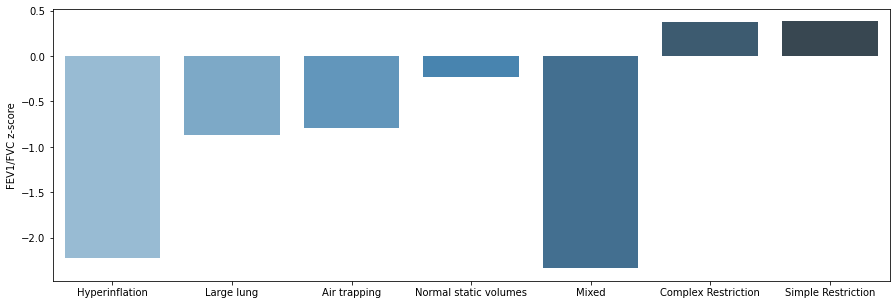

In [149]:
plt.figure(figsize=(15,5))
sns.barplot(x="Int_StaticVolumes", y="fev1fvc_pre_z",errorbar=None, data=PFT, palette="Blues_d", order=["Hyperinflation","Large lung","Air trapping", "Normal static volumes", "Mixed",  "Complex Restriction", "Simple Restriction"])
plt.ylabel('FEV1/FVC z-score')
plt.xlabel('')

Text(0.5, 0, '')

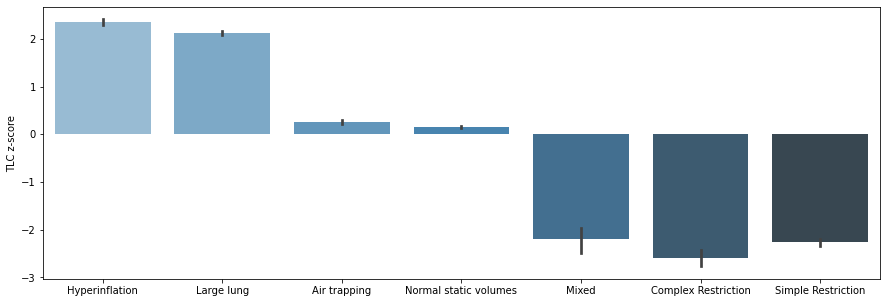

In [150]:
plt.figure(figsize=(15,5))
sns.barplot(x="Int_StaticVolumes", y="tlc_z", data=PFT, palette="Blues_d", order=["Hyperinflation","Large lung","Air trapping", "Normal static volumes", "Mixed",  "Complex Restriction", "Simple Restriction"])
plt.ylabel('TLC z-score')
plt.xlabel('')

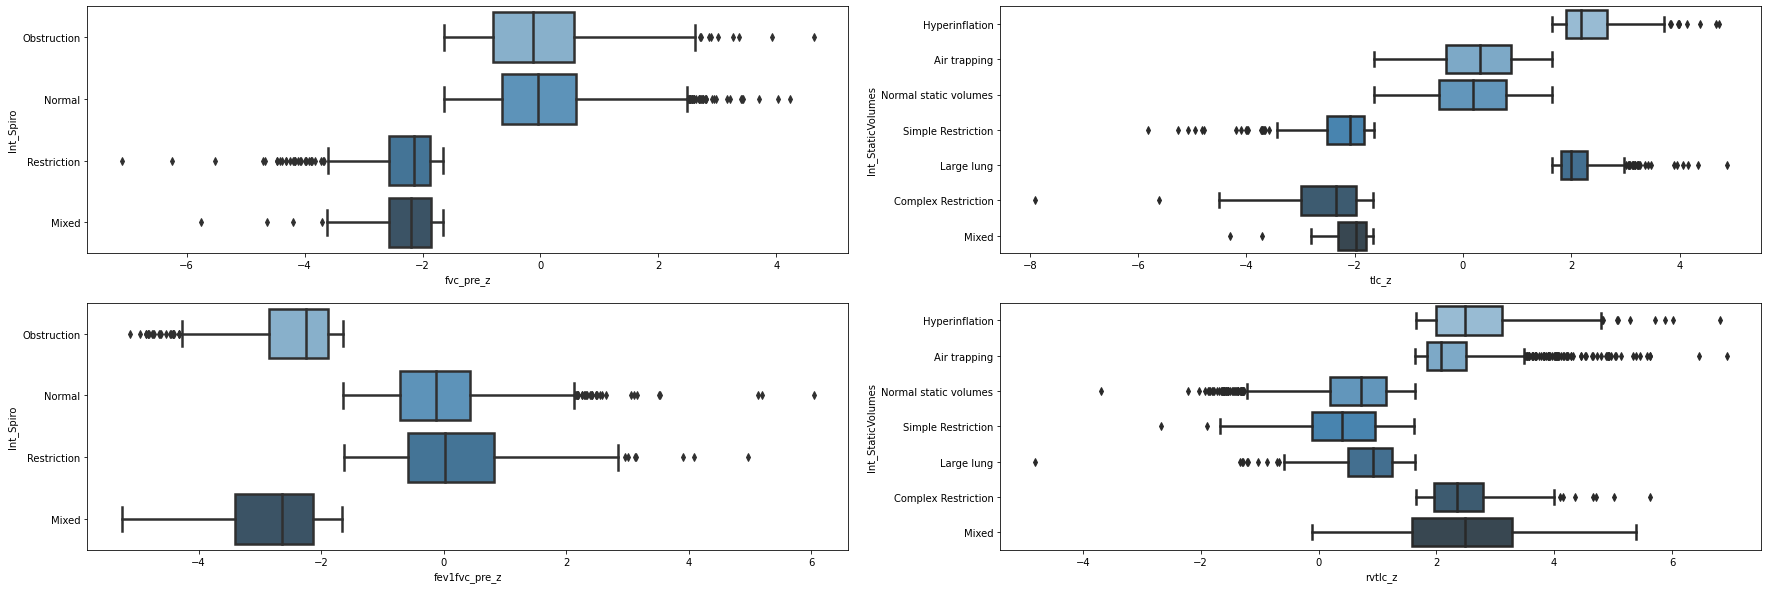

In [153]:
fig, axs = plt.subplots(2,2,figsize=(30,10))

sns.boxplot(x= "fvc_pre_z", y="Int_Spiro", orient="h",  data=PFT, linewidth=2.5, palette="Blues_d", ax=axs[0,0])
sns.boxplot(x= "fev1fvc_pre_z", y="Int_Spiro", orient="h",  data=PFT, linewidth=2.5, palette="Blues_d", ax=axs[1,0])
sns.boxplot(x= "tlc_z", y="Int_StaticVolumes", orient="h",  data=PFT, linewidth=2.5, palette="Blues_d", ax=axs[0,1])
sns.boxplot(x= "rvtlc_z", y="Int_StaticVolumes", orient="h",  data=PFT, linewidth=2.5, palette="Blues_d", ax=axs[1,1])

plt.show()

Difusão

In [154]:
PFT['Int_TLCO'] = np.nan

PFT.loc[(PFT['tlco_z'] < -1.645), 'Int_TLCO'] = 'Abnormal'
PFT.loc[(PFT['tlco_z'] >= -1.645), 'Int_TLCO'] = 'Normal'

Alt_TLCO = PFT.Int_TLCO.unique()
print(Alt_TLCO)

['Abnormal' 'Normal']


In [155]:
PFT.Int_TLCO.value_counts()

Normal      6291
Abnormal    1849
Name: Int_TLCO, dtype: int64

Gravidade (FEV1)

In [156]:
PFT['Int_Severity'] = np.nan
PFT.loc[(PFT['fev1_pre_z'] < -1.645) & (PFT['fev1_pre_z'] >= -2.51), 'Int_Severity'] = 'Mild'
PFT.loc[(PFT['fev1_pre_z'] < -2.51) & (PFT['fev1_pre_z'] >= -4), 'Int_Severity'] = 'Moderate'
PFT.loc[(PFT['fev1_pre_z'] < -4), 'Int_Severity'] = 'Severe'
PFT.loc[(PFT['fev1_pre_z'] >= -1.645), 'Int_Severity'] = 'Normal'

Severity = PFT.Int_Severity.unique()
print(Severity)

['Moderate' 'Normal' 'Mild' 'Severe']


In [157]:
PFT.Int_Severity.value_counts()

Normal      6875
Mild         789
Moderate     434
Severe        42
Name: Int_Severity, dtype: int64

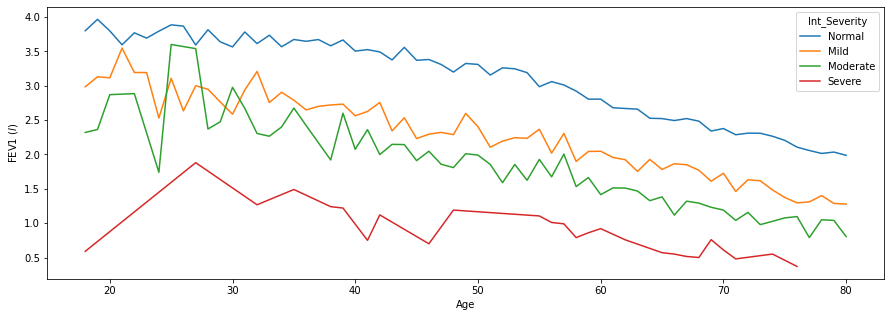

In [158]:
plt.figure(figsize=(15,5))
sns.lineplot(data = PFT, x="age", y = "fev1_pre", hue_order=["Normal","Mild","Moderate","Severe"], hue="Int_Severity",   errorbar=None)
plt.xlabel('Age')
plt.ylabel('FEV1 ($l$)')
plt.show()

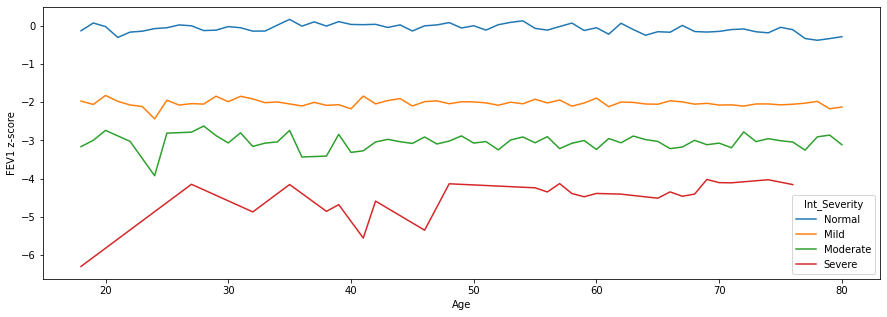

In [159]:
plt.figure(figsize=(15,5))
sns.lineplot(data = PFT, x="age", y = "fev1_pre_z", hue="Int_Severity", hue_order=["Normal","Mild","Moderate","Severe"],  errorbar=None)
plt.ylabel('FEV1 z-score')
plt.xlabel('Age')
plt.show()

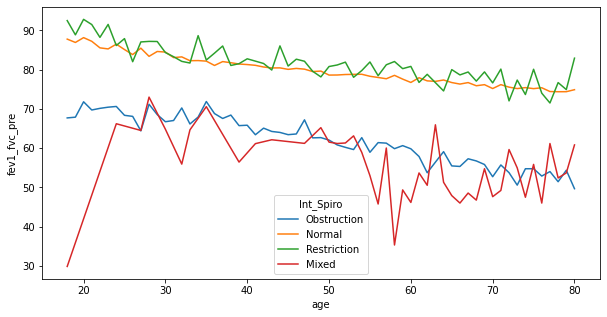

In [160]:
plt.figure(figsize=(10,5))
sns.lineplot(data = PFT, x="age", y = "fev1_fvc_pre", hue="Int_Spiro",   errorbar=None)
plt.show()

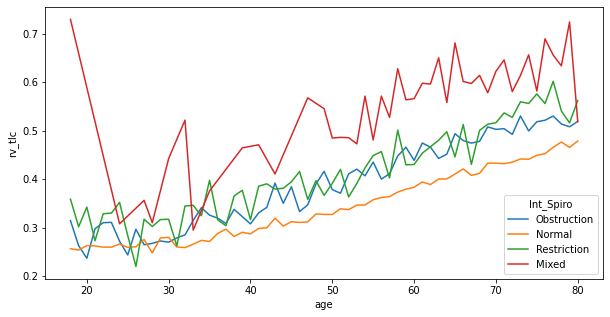

In [161]:
plt.figure(figsize=(10,5))
sns.lineplot(data = PFT, x="age", y = "rv_tlc", hue="Int_Spiro",   errorbar=None)
plt.show()

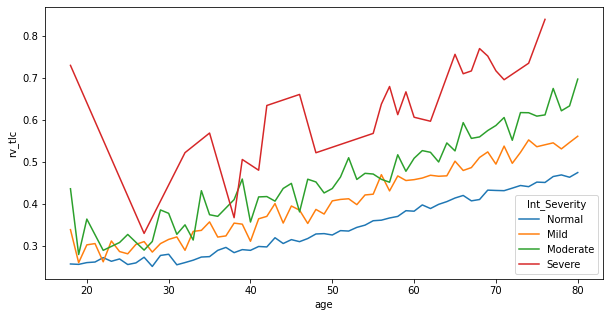

In [162]:
plt.figure(figsize=(10,5))
sns.lineplot(data = PFT, x="age", y = "rv_tlc", hue="Int_Severity", hue_order=["Normal","Mild","Moderate","Severe"],  errorbar=None)
plt.show()

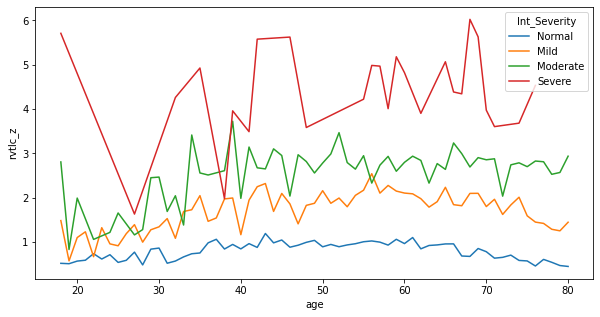

In [163]:
plt.figure(figsize=(10,5))
sns.lineplot(data = PFT, x="age", y = "rvtlc_z", hue="Int_Severity", hue_order=["Normal","Mild","Moderate","Severe"],  errorbar=None)
plt.show()

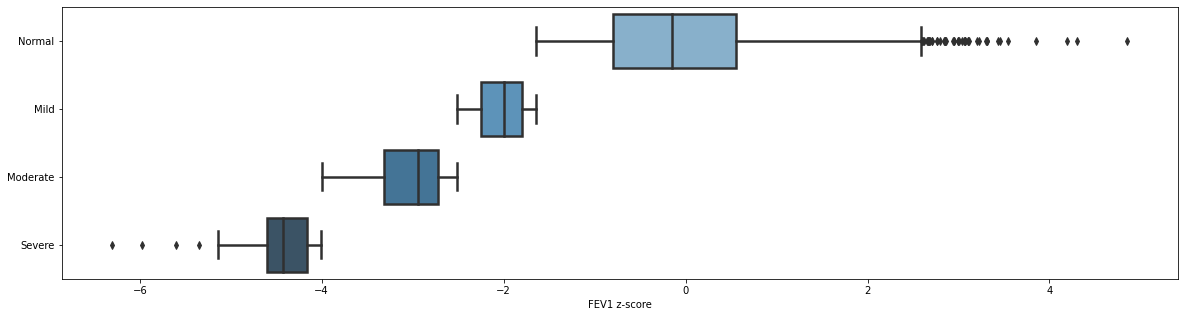

In [164]:
plt.figure(figsize=(20,5))
sns.boxplot(x= "fev1_pre_z", y="Int_Severity", orient="h", order=["Normal","Mild","Moderate","Severe"], data=PFT, linewidth=2.5, palette="Blues_d")
plt.xlabel('FEV1 z-score')
plt.ylabel('')
plt.show()

In [165]:
#verificar se estava bem delimitado pelos z score (PFR moderadamente alterada com fev1 de 3,5l)

In [166]:
#Normal static volumes com intances inferiores a -1.645, corrigir

Resposta ao broncodilatador

In [167]:
PFT['BD_dif']=((PFT['fev1_pos'] - PFT['fev1_pre'])/PFT['fev1_pre_predicted'])*100

In [168]:
PFT.BD_dif.describe()

count    3507.000000
mean        4.723854
std         5.105153
min       -77.257074
25%         1.789484
50%         4.108347
75%         7.045341
max        57.030091
Name: BD_dif, dtype: float64

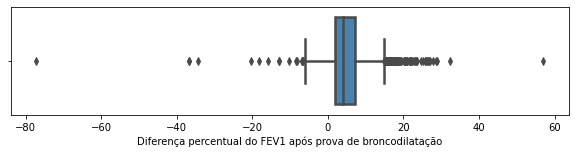

In [169]:
plt.figure(figsize=(10,2))
sns.boxplot(x="BD_dif", data=PFT, linewidth=2.5, palette="Blues_d")
plt.xlabel('Diferença percentual do FEV1 após prova de broncodilatação')
plt.show()

In [170]:
#outliers negativos severos... inferior a 20% do fev1 pp??
#Removê-los/substituir por NaN?

In [171]:
PFT['Bronchodilator'] = np.nan

PFT.loc[(PFT['BD_dif'] > 10), 'Bronchodilator'] = 'Positive'
PFT.loc[(PFT['BD_dif'] <= 10), 'Bronchodilator'] = 'Negative'

BD = PFT.Bronchodilator.unique()
print(BD)

['Negative' nan 'Positive']


In [172]:
PFT.Bronchodilator.value_counts()

Negative    3093
Positive     414
Name: Bronchodilator, dtype: int64

In [173]:
print(PFT.fvc_pos.isnull().sum())

4633


In [174]:
#4633 = (8140-3507)!

Text(0, 0.5, '')

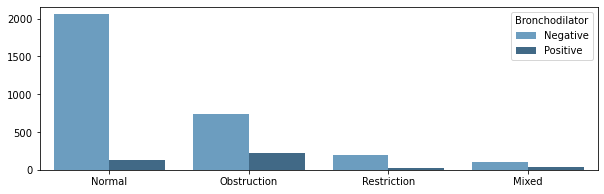

In [175]:
plt.figure(figsize=(10,3))
sns.countplot(x="Int_Spiro", data=PFT, hue="Bronchodilator", palette="Blues_d", order=["Normal","Obstruction","Restriction", "Mixed"])
#rever pois na restrição devia ter a sua maioria no BD e todos/quase todos obstrução e misto devia ter BD
plt.xlabel('')
plt.ylabel('')

In [176]:
PFT_categoricals=PFT[["Int_Spiro","Int_StaticVolumes","Int_TLCO","Int_Severity","Bronchodilator"]]# criação de subset

In [177]:
pd.crosstab(PFT_categoricals['Int_Spiro'],PFT_categoricals['Int_Severity'])

Int_Severity  Mild  Moderate  Normal  Severe
Int_Spiro                                   
Mixed            8       111       0      29
Normal         177         0    6251       0
Obstruction    303       167     502       8
Restriction    301       156     122       5

In [178]:
#Normal e gravidade ligeira = 177 (restrição?)

In [179]:
pd.crosstab(PFT_categoricals['Int_StaticVolumes'],PFT_categoricals['Int_Severity'])

Int_Severity           Mild  Moderate  Normal  Severe
Int_StaticVolumes                                    
Air trapping            380       201     904      19
Complex Restriction      20        76       9       3
Hyperinflation           63        78     201      17
Large lung                7         2     422       0
Mixed                     3        19       0       2
Normal static volumes   200        24    5151       1
Simple Restriction      116        34     188       0

In [180]:
pd.crosstab(PFT_categoricals['Int_StaticVolumes'],PFT_categoricals['Int_TLCO'])

Int_TLCO               Abnormal  Normal
Int_StaticVolumes                      
Air trapping                401    1103
Complex Restriction          66      42
Hyperinflation              128     231
Large lung                   49     382
Mixed                        11      13
Normal static volumes      1004    4372
Simple Restriction          190     148

In [181]:
pd.crosstab(PFT_categoricals['Int_Spiro'],PFT_categoricals['Int_TLCO'])

Int_TLCO     Abnormal  Normal
Int_Spiro                    
Mixed              76      72
Normal           1148    5280
Obstruction       330     650
Restriction       295     289

In [182]:
pd.crosstab(PFT_categoricals['Int_Spiro'],PFT_categoricals['Bronchodilator'])

Bronchodilator  Negative  Positive
Int_Spiro                         
Mixed                108        36
Normal              2056       131
Obstruction          735       229
Restriction          194        18

In [183]:
pd.crosstab(PFT_categoricals['Int_StaticVolumes'],PFT_categoricals['Bronchodilator'])

Bronchodilator         Negative  Positive
Int_StaticVolumes                        
Air trapping                788       149
Complex Restriction          11         0
Hyperinflation              285        66
Large lung                  210        30
Mixed                        16         6
Normal static volumes      1738       162
Simple Restriction           45         1

In [184]:
pd.crosstab(PFT_categoricals['Int_StaticVolumes'],PFT_categoricals['Int_Spiro'])

Int_Spiro              Mixed  Normal  Obstruction  Restriction
Int_StaticVolumes                                             
Air trapping             103     897          272          232
Complex Restriction        0       1            0          107
Hyperinflation            21     123          215            0
Large lung                 0     343           88            0
Mixed                     20       0            4            0
Normal static volumes      4    4917          401           54
Simple Restriction         0     147            0          191

<ipython-input-185-13368befec9b>:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x="Int_Spiro", y="fvc_pre", linewidth=.5, data=PFT, palette="Blues_d", order=["Normal","Obstruction","Restriction", "Mixed"])
C:\Users\marco\anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 85.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\marco\anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\marco\anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\marco\anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWa

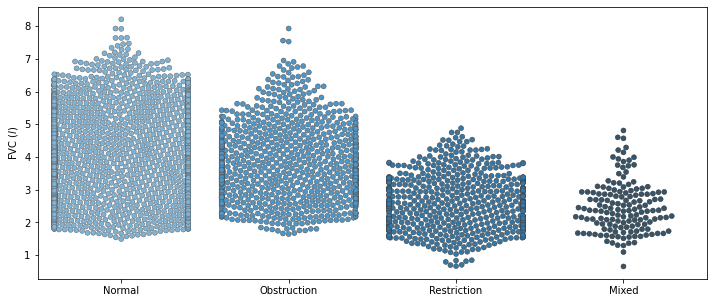

In [185]:
plt.figure(figsize=(12,5))
sns.swarmplot(x="Int_Spiro", y="fvc_pre", linewidth=.5, data=PFT, palette="Blues_d", order=["Normal","Obstruction","Restriction", "Mixed"])
plt.ylabel('FVC ($l$)')
plt.xlabel('')
plt.show()

Text(0.5, 0, '')

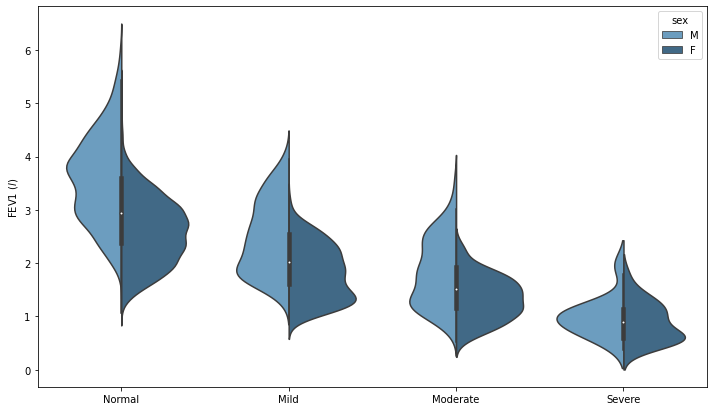

In [186]:
plt.figure(figsize=(12,7))
ax = sns.violinplot(x="Int_Severity", y="fev1_pre", data=PFT, palette="Blues_d", hue="sex",split=True, order=["Normal","Mild","Moderate", "Severe"])
plt.ylabel('FEV1 ($l$)')
plt.xlabel('')

Text(0.5, 0, '')

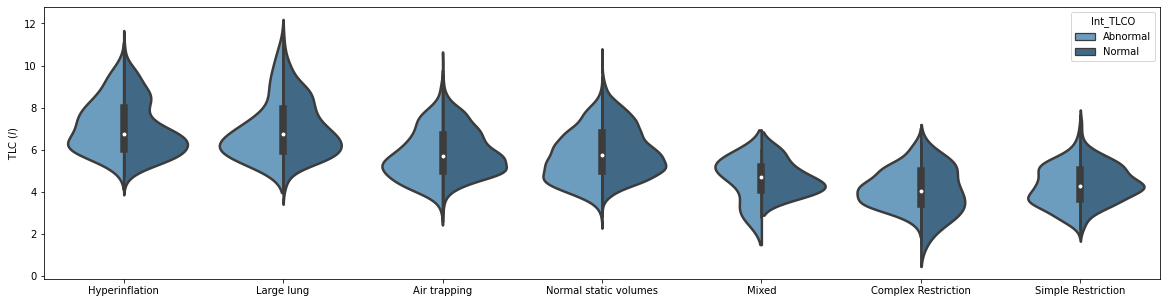

In [187]:
plt.figure(figsize=(20,5))
sns.violinplot(x="Int_StaticVolumes", y="tlc", data=PFT, linewidth=2.5, hue="Int_TLCO", split=True, palette="Blues_d",order=["Hyperinflation","Large lung","Air trapping", "Normal static volumes", "Mixed",  "Complex Restriction", "Simple Restriction"])
plt.ylabel('TLC ($l$)')
plt.xlabel('')

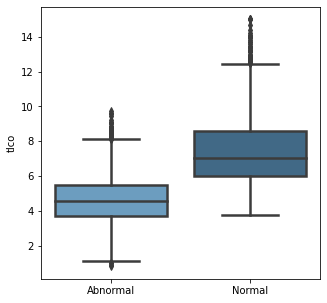

In [188]:
plt.figure(figsize=(5,5))
sns.boxplot(x="Int_TLCO", y="tlco", data=PFT, linewidth=2.5, palette="Blues_d",)
plt.xlabel('')
plt.show()

In [189]:
PFT['rvtlc_cat'] = np.nan

PFT.loc[(PFT['rvtlc_z'] < 1.645), 'rvtlc_cat'] = 'Normal'
PFT.loc[(PFT['rvtlc_z'] >= 1.645), 'rvtlc_cat'] = 'Abnormal'

Alt_RV_TLC = PFT.rvtlc_cat.unique()
print(Alt_RV_TLC)

['Abnormal' 'Normal']


In [190]:
PFT.rvtlc_cat.value_counts()

Normal      6151
Abnormal    1989
Name: rvtlc_cat, dtype: int64

Text(0.5, 0, 'Espirometria')

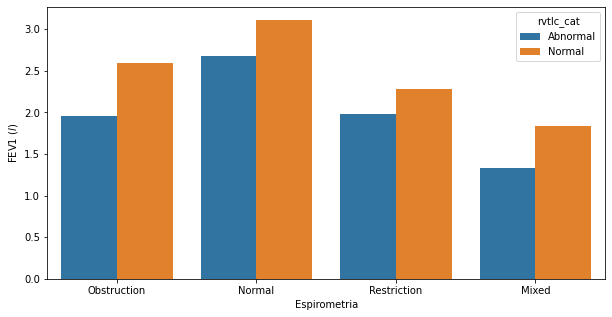

In [191]:
plt.figure(figsize=(10,5))
sns.barplot(x="Int_Spiro", linewidth=2.5, y="fev1_pre", data=PFT, errorbar=None,  hue="rvtlc_cat")
plt.ylabel('FEV1 ($l$)')
plt.xlabel('Espirometria')

In [193]:
#with pd.ExcelWriter("PFT_clean.xlsx") as writer:
   # PFT.to_excel(writer) #guardar base de dados "limpa" para excel